# Based on https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/stacked-ensembles.html

In [33]:
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.1" 2018-10-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.1+13-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /Users/fernandes/anaconda3/envs/h2o/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmpufhyequl
  JVM stdout: /var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmpufhyequl/h2o_fernandes_started_from_python.out
  JVM stderr: /var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/tmpufhyequl/h2o_fernandes_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Brussels
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_fernandes_vr84fc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
df = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/smalldata/wine/winequality-redwhite-no-BOM.csv")

response = "quality"

predictors = [
  "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide",
  "total sulfur dioxide", "density", "pH", "sulphates", "alcohol",  "type"
]


train, test = df.split_frame(seed=1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
df.head()

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,white
6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,white
8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,white
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,white
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6,white
8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6,white
6.2,0.32,0.16,7,0.045,30,136,0.9949,3.18,0.47,9.6,6,white
7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6,white
6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6,white
8.1,0.22,0.43,1.5,0.044,28,129,0.9938,3.22,0.45,11,6,white


In [5]:
df.describe()

Rows:6497
Cols:13




,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
type,real,real,real,real,real,real,real,real,real,real,real,int,enum
mins,3.8,0.08,0.0,0.6,0.009,1.0,6.0,0.98711,2.72,0.22,8.0,3.0,
mean,7.215307064799138,0.33966599969216565,0.31863321533015243,5.443235339387409,0.05603386178236108,30.52531937817455,115.7445744189626,0.994696633830999,3.2185008465445586,0.5312682776666153,10.491800831149456,5.818377712790519,
maxs,15.9,1.58,1.66,65.8,0.611,289.0,440.0,1.03898,4.01,2.0,14.9,9.0,
sigma,1.2964337577998157,0.1646364740846788,0.14531786489759152,4.757803743147418,0.03503360137245907,17.7493997720025,56.5218545226303,0.002998673003719035,0.16078720210398753,0.14880587361449027,1.1927117488689818,0.8732552715311248,
zeros,0,0,151,0,0,0,0,0,0,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6.0,white
1,6.3,0.3,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6.0,white
2,8.1,0.28,0.4,6.9,0.05,30.0,97.0,0.9951,3.26,0.44,10.1,6.0,white


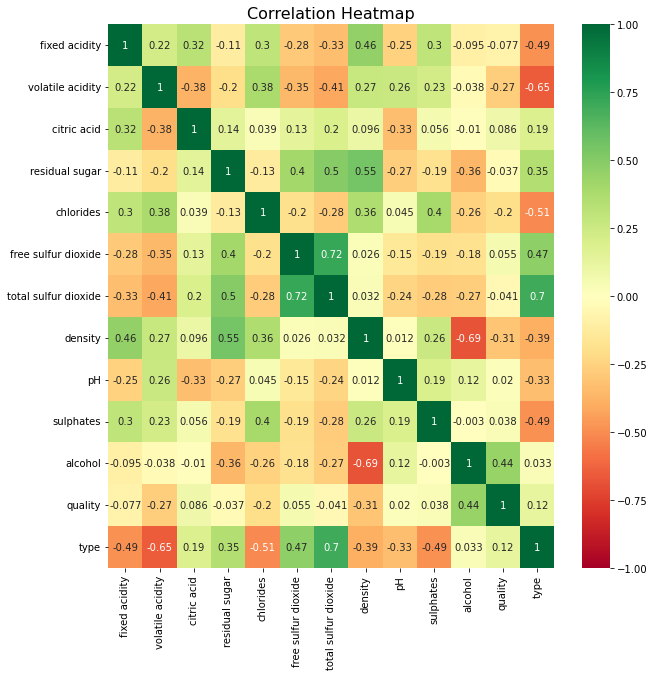

In [35]:
plt.figure(figsize=(10,10))
corr = df.cor().as_data_frame()
corr.index = df.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [6]:
df['type'].unique()

C1
red
white


In [7]:
train.shape

(4865, 13)

In [8]:
test.shape

(1632, 13)

In [9]:
# Identify predictors and response
x = train.columns
y = "type"
x.remove(y)

In [10]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [11]:
# Number of CV folds (to generate level-one data for stacking)
nfolds = 5

# There are a few ways to assemble a list of models to stack together:
# 1. Train individual models and put them in a list
# 2. Train a grid of models
# 3. Train several grids of models
# Note: All base models must have the same cross-validation folds and
# the cross-validated predicted values must be kept.


# 1. Generate a 2-model ensemble (GBM + RF)

# Train and cross-validate a GBM
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1645371969385_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,10.0,1580.0,3.0,3.0,3.0,8.0,8.0,8.0




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.013012050881593209
RMSE: 0.11407037688021027
LogLoss: 0.08449301223992525
Mean Per-Class Error: 0.014207560819158582
AUC: 0.995652024757292
AUCPR: 0.9974529802118592
Gini: 0.991304049514584

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6127640492395385: 


,,red,white,Error,Rate
0,red,1149.0,29.0,0.0246,(29.0/1178.0)
1,white,14.0,3673.0,0.0038,(14.0/3687.0)
2,Total,1163.0,3702.0,0.0088,(43.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.612764,0.994181,177.0
1,max f2,0.359393,0.995729,212.0
2,max f0point5,0.743887,0.993581,155.0
3,max accuracy,0.612764,0.991161,177.0
4,max precision,0.963816,1.000000,0.0
5,max recall,0.144394,1.000000,268.0
6,max specificity,0.963816,1.000000,0.0
7,max absolute_mcc,0.612764,0.975847,177.0
8,max min_per_class_accuracy,0.798502,0.985354,140.0
9,max mean_per_class_accuracy,0.743887,0.986476,155.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.584584,0.961322,1.316253,1.316253,0.997539,0.961333,0.997539,0.961333,0.769460,0.769460,31.625323,31.625323,0.763518
1,2,0.602467,0.958502,1.304334,1.315899,0.988506,0.959162,0.997271,0.961269,0.023325,0.792785,30.433427,31.589945,0.785994
2,3,0.705858,0.932511,1.316878,1.316043,0.998012,0.950011,0.997379,0.959620,0.136154,0.928940,31.687769,31.604273,0.921299
3,4,0.800411,0.137761,0.751542,1.249358,0.569565,0.624597,0.946841,0.920043,0.071060,1.000000,-24.845815,24.935799,0.824278
4,5,0.998972,0.088269,0.000000,1.001029,0.000000,0.094016,0.758642,0.755858,0.000000,1.000000,-100.000000,0.102881,0.004244
5,6,1.000000,0.066699,0.000000,1.000000,0.000000,0.066699,0.757862,0.755149,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.016111421989165587
RMSE: 0.12693077636714267
LogLoss: 0.09300951965085734
Mean Per-Class Error: 0.022083625163067777
AUC: 0.9929594781462698
AUCPR: 0.9952014388238305
Gini: 0.9859189562925397

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5811660326067021: 


,,red,white,Error,Rate
0,red,1133.0,45.0,0.0382,(45.0/1178.0)
1,white,22.0,3665.0,0.006,(22.0/3687.0)
2,Total,1155.0,3710.0,0.0138,(67.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.581166,0.990942,222.0
1,max f2,0.452123,0.993510,248.0
2,max f0point5,0.777996,0.991471,175.0
3,max accuracy,0.581166,0.986228,222.0
4,max precision,0.966182,1.000000,0.0
5,max recall,0.112138,1.000000,372.0
6,max specificity,0.966182,1.000000,0.0
7,max absolute_mcc,0.581166,0.962306,222.0
8,max min_per_class_accuracy,0.802907,0.979626,165.0
9,max mean_per_class_accuracy,0.777996,0.981677,175.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010689,0.962518,1.294126,1.294126,0.980769,0.963039,0.980769,0.963039,0.013832,0.013832,29.412593,29.412593,0.012983
1,2,0.126619,0.962010,1.314822,1.313075,0.996454,0.962011,0.995130,0.962098,0.152427,0.166260,31.482187,31.307481,0.163713
2,3,0.246249,0.962000,1.312699,1.312892,0.994845,0.962000,0.994992,0.962050,0.157038,0.323298,31.269940,31.289243,0.318205
3,4,0.361562,0.961729,1.314797,1.313500,0.996435,0.961730,0.995452,0.961948,0.151614,0.474912,31.479685,31.349981,0.468121
4,5,0.478726,0.961537,1.319501,1.314969,1.000000,0.961542,0.996565,0.961849,0.154597,0.629509,31.950095,31.496853,0.622718
5,6,0.600000,0.961474,1.315028,1.314981,0.996610,0.961474,0.996574,0.961773,0.159479,0.788988,31.502806,31.498056,0.780499
6,7,0.600000,0.961469,0.000000,1.314981,0.000000,0.000000,0.996574,0.961773,0.000000,0.788988,-100.000000,31.498056,0.780499
7,8,0.700308,0.933251,1.308685,1.314079,0.991803,0.951588,0.995891,0.960314,0.131272,0.920260,30.868537,31.407887,0.908376
8,9,0.800000,0.161521,0.797142,1.249661,0.604124,0.646570,0.947071,0.921217,0.079468,0.999729,-20.285819,24.966097,0.824856
9,10,0.913669,0.089403,0.002386,1.094488,0.001808,0.102403,0.829471,0.819349,0.000271,1.000000,-99.761392,9.448819,0.356537




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.987050,0.002131,0.990750,0.986639,0.985611,0.985611,0.986639
1,auc,0.993416,0.003787,0.999348,0.993260,0.991068,0.989384,0.994018
2,err,0.012950,0.002131,0.009250,0.013361,0.014388,0.014388,0.013361
3,err_count,12.600000,2.073644,9.000000,13.000000,14.000000,14.000000,13.000000
4,f0point5,0.989951,0.000790,0.991124,0.990005,0.989710,0.988922,0.989992
5,f1,0.991476,0.001414,0.993931,0.991210,0.990515,0.990528,0.991198
6,f2,0.993008,0.002141,0.996754,0.992418,0.991321,0.992139,0.992408
7,lift_top_group,1.317676,0.002852,1.318428,1.313753,1.320217,1.320217,1.315764
8,logloss,0.093010,0.006229,0.082883,0.092557,0.097671,0.098541,0.093395
9,max_per_class_error,0.034803,0.001864,0.034043,0.034043,0.033898,0.038136,0.033898



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-20 16:46:22,2.147 sec,0.0,0.428377,0.553532,0.500000,0.757862,1.000000,0.242138
1,,2022-02-20 16:46:22,2.196 sec,1.0,0.344820,0.395236,0.982459,0.990142,1.307675,0.024872
2,,2022-02-20 16:46:22,2.231 sec,2.0,0.285993,0.307857,0.991487,0.995022,1.313472,0.018294
3,,2022-02-20 16:46:22,2.266 sec,3.0,0.242263,0.249311,0.991583,0.995054,1.313457,0.015827
4,,2022-02-20 16:46:22,2.544 sec,4.0,0.209781,0.207631,0.993861,0.996555,1.315528,0.013977
5,,2022-02-20 16:46:22,2.718 sec,5.0,0.183273,0.174249,0.993999,0.996593,1.315512,0.013566
6,,2022-02-20 16:46:22,2.896 sec,6.0,0.162020,0.147689,0.994253,0.996636,1.315426,0.011922
7,,2022-02-20 16:46:23,3.080 sec,7.0,0.146168,0.126838,0.995366,0.997319,1.316304,0.011511
8,,2022-02-20 16:46:23,3.268 sec,8.0,0.133358,0.109924,0.995440,0.997407,1.316303,0.010483
9,,2022-02-20 16:46:23,3.447 sec,9.0,0.124001,0.096958,0.995533,0.997434,1.316302,0.009866



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total sulfur dioxide,1224.683594,1.000000,0.543086
1,chlorides,845.633728,0.690492,0.374996
2,volatile acidity,84.910576,0.069333,0.037654
3,sulphates,40.797718,0.033313,0.018092
4,density,28.987041,0.023669,0.012854
5,fixed acidity,18.144394,0.014816,0.008046
6,pH,9.020085,0.007365,0.004000
7,citric acid,2.012474,0.001643,0.000892
8,residual sugar,0.856147,0.000699,0.000380
9,free sulfur dioxide,0.000000,0.000000,0.000000


In [12]:
# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x=x, y=y, training_frame=train)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1645371969385_129


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,54660.0,11.0,19.0,13.64,60.0,105.0,82.4




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.006606292222335774
RMSE: 0.08127910077218974
LogLoss: 0.05455083707362567
Mean Per-Class Error: 0.008724960778544172
AUC: 0.9977411112231616
AUCPR: 0.9986604706907763
Gini: 0.9954822224463231

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5625: 


,,red,white,Error,Rate
0,red,1160.0,18.0,0.0153,(18.0/1178.0)
1,white,8.0,3679.0,0.0022,(8.0/3687.0)
2,Total,1168.0,3697.0,0.0053,(26.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.562500,0.996479,76.0
1,max f2,0.454545,0.997779,85.0
2,max f0point5,0.739130,0.996293,56.0
3,max accuracy,0.562500,0.994656,76.0
4,max precision,0.960000,0.998775,5.0
5,max recall,0.190476,1.000000,117.0
6,max specificity,1.000000,0.996604,0.0
7,max absolute_mcc,0.562500,0.985412,76.0
8,max min_per_class_accuracy,0.739130,0.991321,56.0
9,max mean_per_class_accuracy,0.631579,0.991870,69.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.89 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.668243,1.000000,1.317877,1.317877,0.998770,1.000000,0.998770,1.000000,0.880662,0.880662,31.787745,31.787745,0.877266
1,2,0.702980,0.944444,1.296078,1.316800,0.982249,0.951580,0.997953,0.997607,0.045023,0.925685,29.607786,31.680022,0.919743
2,3,0.800617,0.062500,0.761144,1.249037,0.576842,0.579095,0.946598,0.946569,0.074315,1.000000,-23.885629,24.903723,0.823430
3,4,1.000000,0.000000,0.000000,1.000000,0.000000,0.005342,0.757862,0.758904,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.006343624529286418
RMSE: 0.0796468739454752
LogLoss: 0.042374869212582635
Mean Per-Class Error: 0.009013797387507983
AUC: 0.9986159097052323
AUCPR: 0.9992124603706329
Gini: 0.9972318194104646

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5266666662693024: 


,,red,white,Error,Rate
0,red,1159.0,19.0,0.0161,(19.0/1178.0)
1,white,7.0,3680.0,0.0019,(7.0/3687.0)
2,Total,1166.0,3699.0,0.0053,(26.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.526667,0.996480,27.0
1,max f2,0.500000,0.997670,29.0
2,max f0point5,0.580000,0.996152,24.0
3,max accuracy,0.580000,0.994656,24.0
4,max precision,0.970000,0.999386,4.0
5,max recall,0.320000,1.000000,38.0
6,max specificity,1.000000,0.998302,0.0
7,max absolute_mcc,0.580000,0.985424,24.0
8,max min_per_class_accuracy,0.740000,0.990662,17.0
9,max mean_per_class_accuracy,0.580000,0.992142,24.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.84 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.597328,1.00,1.318593,1.318593,0.999312,1.000000,0.999312,1.000000,0.787632,0.787632,31.859283,31.859283,0.785934
1,2,0.669270,0.98,1.319501,1.318690,1.000000,0.980219,0.999386,0.997874,0.094928,0.882560,31.950095,31.869045,0.880863
2,3,0.714286,0.94,1.307451,1.317982,0.990868,0.951918,0.998849,0.994977,0.058855,0.941416,30.745071,31.798210,0.938020
3,4,0.809250,0.06,0.616910,1.235712,0.467532,0.488427,0.936500,0.935535,0.058584,1.000000,-38.309047,23.571247,0.787776
4,5,1.000000,0.00,0.000000,1.000000,0.000000,0.006940,0.757862,0.758405,0.000000,1.000000,-100.000000,0.000000,0.000000




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.995067,0.002228,0.998972,0.993834,0.994861,0.993834,0.993834
1,auc,0.998620,0.002150,0.999977,0.999513,0.999753,0.999031,0.994826
2,err,0.004933,0.002228,0.001028,0.006166,0.005139,0.006166,0.006166
3,err_count,4.800000,2.167948,1.000000,6.000000,5.000000,6.000000,6.000000
4,f0point5,0.995303,0.002296,0.998917,0.993538,0.996205,0.993529,0.994326
5,f1,0.996754,0.001465,0.999323,0.995951,0.996610,0.995946,0.995940
6,f2,0.998211,0.001026,0.999729,0.998377,0.997016,0.998374,0.997560
7,lift_top_group,1.318608,0.001831,1.318428,1.318428,1.320217,1.320217,1.315749
8,logloss,0.042375,0.029714,0.024529,0.030175,0.028603,0.033343,0.095224
9,max_per_class_error,0.017822,0.009202,0.004255,0.025532,0.012712,0.025424,0.021186



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-20 16:46:30,5.522 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-20 16:46:30,5.537 sec,1.0,0.117209,0.474488,0.983634,0.991744,1.310511,0.013738
2,,2022-02-20 16:46:30,5.556 sec,2.0,0.148215,0.717686,0.970675,0.983269,1.299509,0.021709
3,,2022-02-20 16:46:30,5.568 sec,3.0,0.141664,0.612284,0.973276,0.984371,1.300399,0.020022
4,,2022-02-20 16:46:30,5.579 sec,4.0,0.139302,0.531970,0.976447,0.986450,1.302969,0.020962
5,,2022-02-20 16:46:30,5.591 sec,5.0,0.126698,0.387102,0.982036,0.989521,1.306553,0.017857
6,,2022-02-20 16:46:30,5.603 sec,6.0,0.121130,0.315123,0.984989,0.991192,1.308554,0.017188
7,,2022-02-20 16:46:30,5.618 sec,7.0,0.120183,0.293515,0.985903,0.991731,1.309216,0.016913
8,,2022-02-20 16:46:30,5.628 sec,8.0,0.114143,0.233002,0.988756,0.993332,1.311183,0.014132
9,,2022-02-20 16:46:30,5.645 sec,9.0,0.112956,0.217972,0.989357,0.993676,1.311591,0.013799



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total sulfur dioxide,11527.931641,1.000000,0.324174
1,chlorides,9416.321289,0.816827,0.264794
2,volatile acidity,5108.910645,0.443177,0.143666
3,free sulfur dioxide,2417.520264,0.209710,0.067982
4,density,1778.740967,0.154298,0.050020
5,sulphates,1714.332031,0.148711,0.048208
6,residual sugar,1160.602295,0.100677,0.032637
7,fixed acidity,899.312317,0.078012,0.025289
8,pH,637.423889,0.055294,0.017925
9,citric acid,511.690796,0.044387,0.014389


In [13]:
# Train a stacked ensemble using the GBM and GLM above
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
                                       base_models=[my_gbm, my_rf])
ensemble.train(x=x, y=y, training_frame=train)



stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  my_ensemble_binomial

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0005206967082843654
RMSE: 0.022818779728205566
LogLoss: 0.006643608632038423
Null degrees of freedom: 4864
Residual degrees of freedom: 4862
Null deviance: 5385.861792992691
Residual deviance: 64.64231198973413
AIC: 70.64231198973413
AUC: 0.9999986185574701
AUCPR: 0.9999995592951486
Gini: 0.9999972371149402

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7476757138891709: 


,,red,white,Error,Rate
0,red,1178.0,0.0,0.0,(0.0/1178.0)
1,white,1.0,3686.0,0.0003,(1.0/3687.0)
2,Total,1179.0,3686.0,0.0002,(1.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.747676,0.999864,218.0
1,max f2,0.747676,0.999783,218.0
2,max f0point5,0.747676,0.999946,218.0
3,max accuracy,0.747676,0.999794,218.0
4,max precision,0.995357,1.000000,0.0
5,max recall,0.318150,1.000000,224.0
6,max specificity,0.995357,1.000000,0.0
7,max absolute_mcc,0.747676,0.999440,218.0
8,max min_per_class_accuracy,0.747676,0.999729,218.0
9,max mean_per_class_accuracy,0.747676,0.999864,218.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.557862,0.995343,1.319501,1.319501,1.000000,0.995344,1.000000,0.995344,0.736100,0.736100,31.950095,31.950095,0.736100
1,2,0.617266,0.995251,1.319501,1.319501,1.000000,0.995286,1.000000,0.995338,0.078384,0.814483,31.950095,31.950095,0.814483
2,3,0.700308,0.994142,1.319501,1.319501,1.000000,0.994751,1.000000,0.995268,0.109574,0.924057,31.950095,31.950095,0.924057
3,4,0.800206,0.004099,0.760206,1.249679,0.576132,0.582315,0.947085,0.943716,0.075943,1.000000,-23.979369,24.967891,0.825127
4,5,0.999178,0.002746,0.000000,1.000823,0.000000,0.002886,0.758486,0.756363,0.000000,1.000000,-100.000000,0.082288,0.003396
5,6,1.000000,0.002605,0.000000,1.000000,0.000000,0.002605,0.757862,0.755743,0.000000,1.000000,-100.000000,0.000000,0.000000


In [14]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)


In [15]:
# Compare to base learner performance on the test set
perf_gbm_test = my_gbm.model_performance(test)
perf_rf_test = my_rf.model_performance(test)
baselearner_best_auc_test = max(perf_gbm_test.auc(), perf_rf_test.auc())
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))

Best Base-learner Test AUC:  0.9995616194385982
Ensemble Test AUC:  0.9995969252556239


In [16]:

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)

pred

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,red,white
white,0.00558417,0.994416
white,0.00465659,0.995343
white,0.00465659,0.995343
white,0.00465659,0.995343
white,0.00608031,0.99392
white,0.00465659,0.995343
white,0.00465659,0.995343
white,0.0150703,0.98493
white,0.00465659,0.995343
white,0.00465659,0.995343


In [17]:
# 2. Generate a random grid of models and stack them together

# Specify GBM hyperparameters for the grid
hyper_params = {"learn_rate": [0.01, 0.03],
                "max_depth": [3, 4, 5, 6, 9],
                "sample_rate": [0.7, 0.8, 0.9, 1.0],
                "col_sample_rate": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
search_criteria = {"strategy": "RandomDiscrete", "max_models": 3, "seed": 1}

In [18]:
# Train the grid
grid = H2OGridSearch(model=H2OGradientBoostingEstimator(ntrees=10,
                                                        seed=1,
                                                        nfolds=nfolds,
                                                        fold_assignment="Modulo",
                                                        keep_cross_validation_predictions=True),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id="gbm_grid_binomial")
grid.train(x=x, y=y, training_frame=train)

# Train a stacked ensemble using the GBM grid
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_gbm_grid_binomial",
                                       base_models=grid.model_ids)
ensemble.train(x=x, y=y, training_frame=train)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  my_ensemble_gbm_grid_binomial

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.005806272472464739
RMSE: 0.07619890073002851
LogLoss: 0.032926521782810345
Null degrees of freedom: 4864
Residual degrees of freedom: 4861
Null deviance: 5385.861792992691
Residual deviance: 320.37505694674473
AIC: 328.37505694674473
AUC: 0.9993618886713885
AUCPR: 0.9997848970676628
Gini: 0.9987237773427771

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6629734628607193: 


,,red,white,Error,Rate
0,red,1158.0,20.0,0.017,(20.0/1178.0)
1,white,6.0,3681.0,0.0016,(6.0/3687.0)
2,Total,1164.0,3701.0,0.0053,(26.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.662973,0.996481,204.0
1,max f2,0.455333,0.997617,218.0
2,max f0point5,0.824781,0.995711,186.0
3,max accuracy,0.662973,0.994656,204.0
4,max precision,0.988404,1.000000,0.0
5,max recall,0.071727,1.000000,268.0
6,max specificity,0.988404,1.000000,0.0
7,max absolute_mcc,0.662973,0.985410,204.0
8,max min_per_class_accuracy,0.915192,0.988964,165.0
9,max mean_per_class_accuracy,0.770435,0.991157,195.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010277,0.988229,1.319501,1.319501,1.000000,0.988282,1.000000,0.988282,0.013561,0.013561,31.950095,31.950095,0.013561
1,2,0.028777,0.988206,1.319501,1.319501,1.000000,0.988209,1.000000,0.988235,0.024410,0.037971,31.950095,31.950095,0.037971
2,3,0.030832,0.988204,1.319501,1.319501,1.000000,0.988205,1.000000,0.988233,0.002712,0.040683,31.950095,31.950095,0.040683
3,4,0.042754,0.988199,1.319501,1.319501,1.000000,0.988200,1.000000,0.988224,0.015731,0.056414,31.950095,31.950095,0.056414
4,5,0.084070,0.988197,1.319501,1.319501,1.000000,0.988197,1.000000,0.988210,0.054516,0.110930,31.950095,31.950095,0.110930
5,6,0.101336,0.988194,1.319501,1.319501,1.000000,0.988195,1.000000,0.988208,0.022783,0.133713,31.950095,31.950095,0.133713
6,7,0.185200,0.988181,1.319501,1.319501,1.000000,0.988184,1.000000,0.988197,0.110659,0.244372,31.950095,31.950095,0.244372
7,8,0.200617,0.988176,1.319501,1.319501,1.000000,0.988178,1.000000,0.988196,0.020342,0.264714,31.950095,31.950095,0.264714
8,9,0.312025,0.988174,1.319501,1.319501,1.000000,0.988175,1.000000,0.988188,0.147003,0.411717,31.950095,31.950095,0.411717
9,10,0.400822,0.988134,1.319501,1.319501,1.000000,0.988159,1.000000,0.988182,0.117168,0.528885,31.950095,31.950095,0.528885


In [19]:
# Eval ensemble performance on the test data
perf_stack_test = ensemble.model_performance(test)

# Compare to base learner performance on the test set
baselearner_best_auc_test = max([h2o.get_model(model).model_performance(test_data=test).auc() for model in grid.model_ids])
stack_auc_test = perf_stack_test.auc()
print("Best Base-learner Test AUC:  {0}".format(baselearner_best_auc_test))
print("Ensemble Test AUC:  {0}".format(stack_auc_test))


Best Base-learner Test AUC:  0.9988584452495043
Ensemble Test AUC:  0.9989143461264615


In [20]:

# Generate predictions on a test set (if neccessary)
pred = ensemble.predict(test)
pred

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,red,white
white,0.0119229,0.988077
white,0.0118187,0.988181
white,0.0118148,0.988185
white,0.0118714,0.988129
white,0.0153835,0.984616
white,0.0118261,0.988174
white,0.0118261,0.988174
white,0.0309334,0.969067
white,0.011876,0.988124
white,0.0118032,0.988197


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## my_ensemble_gbm_grid_binomial


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5242186519237882: 


,,red,white,Error,Rate
0,red,408.0,13.0,0.0309,(13.0/421.0)
1,white,2.0,1209.0,0.0017,(2.0/1211.0)
2,Total,410.0,1222.0,0.0092,(15.0/1632.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

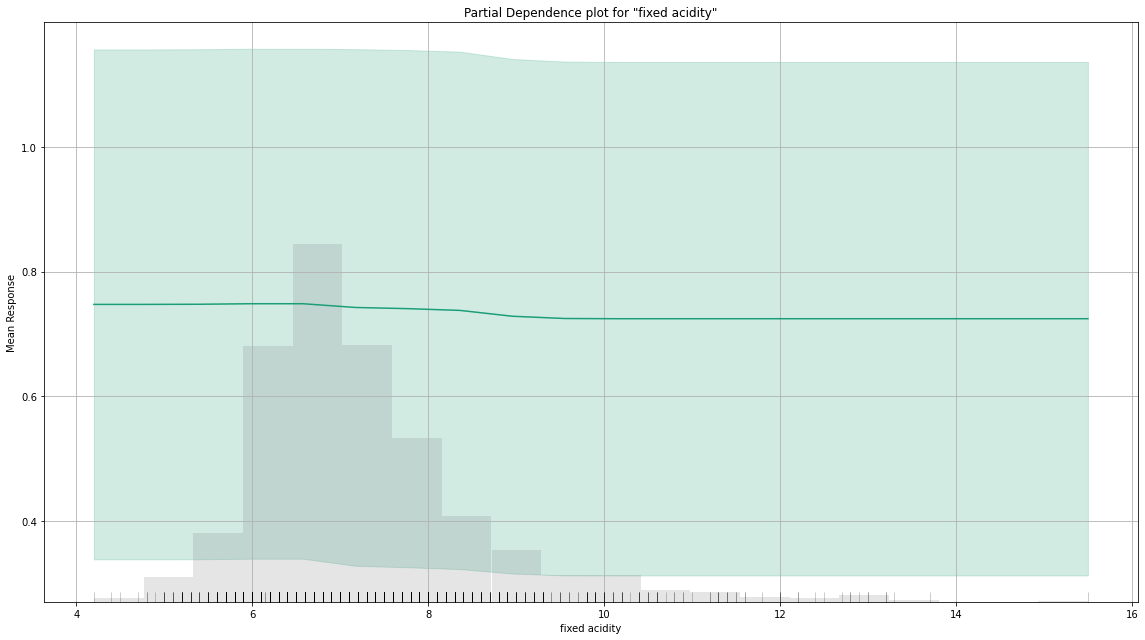

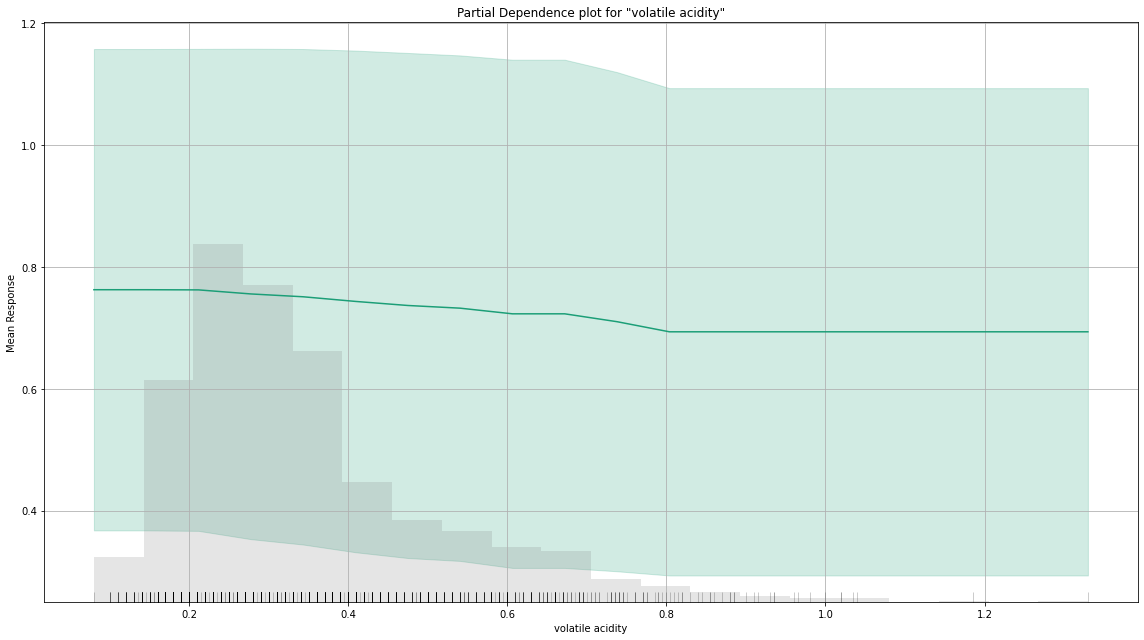

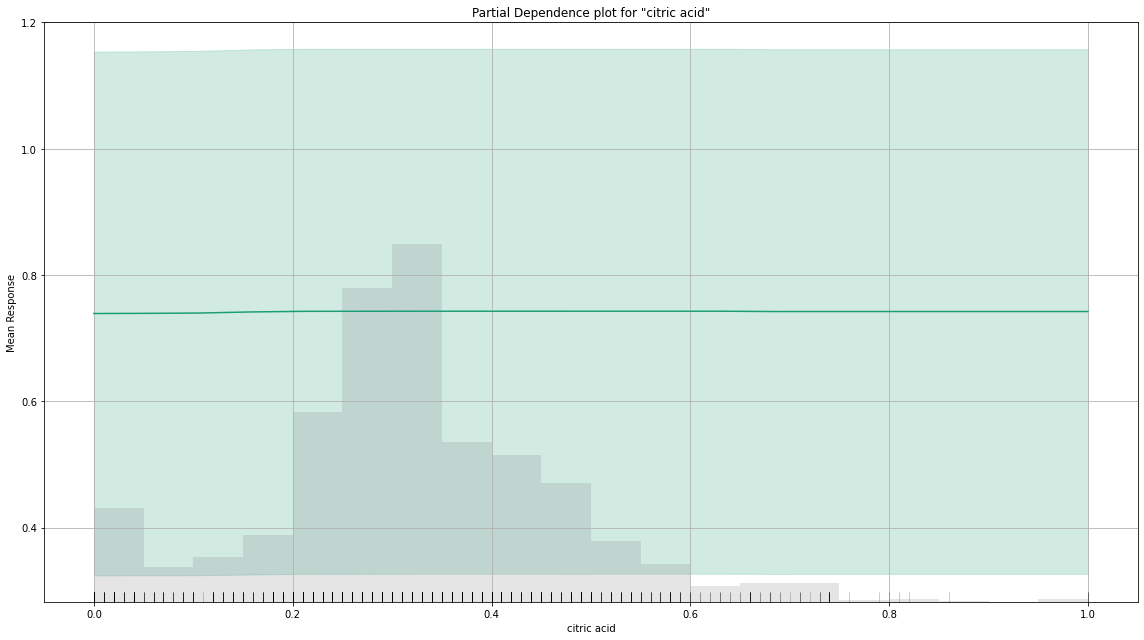

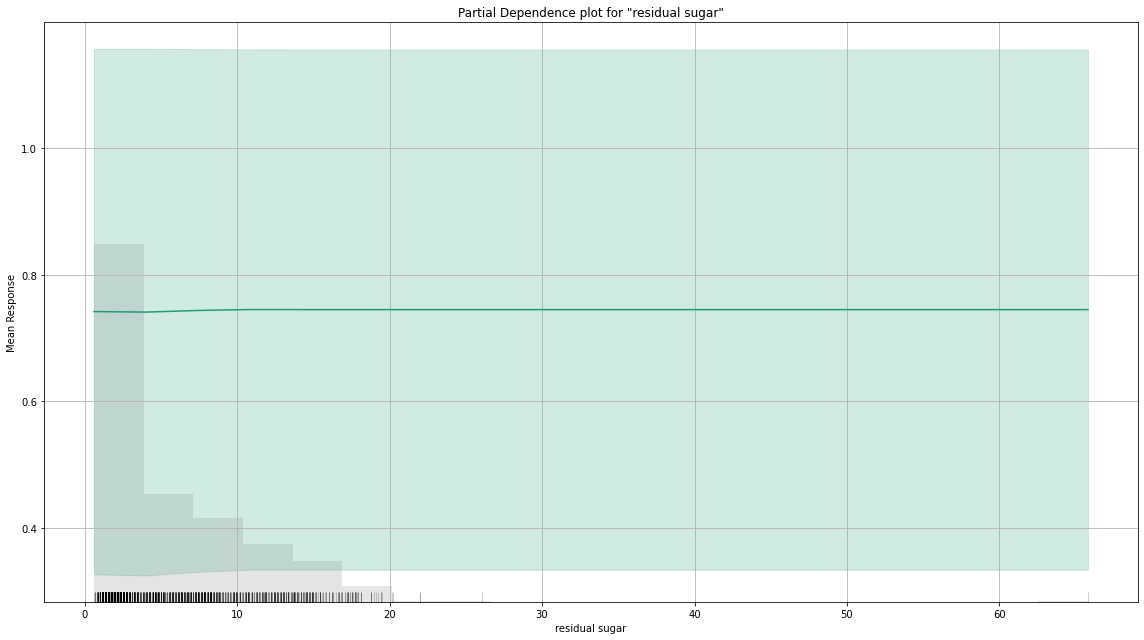

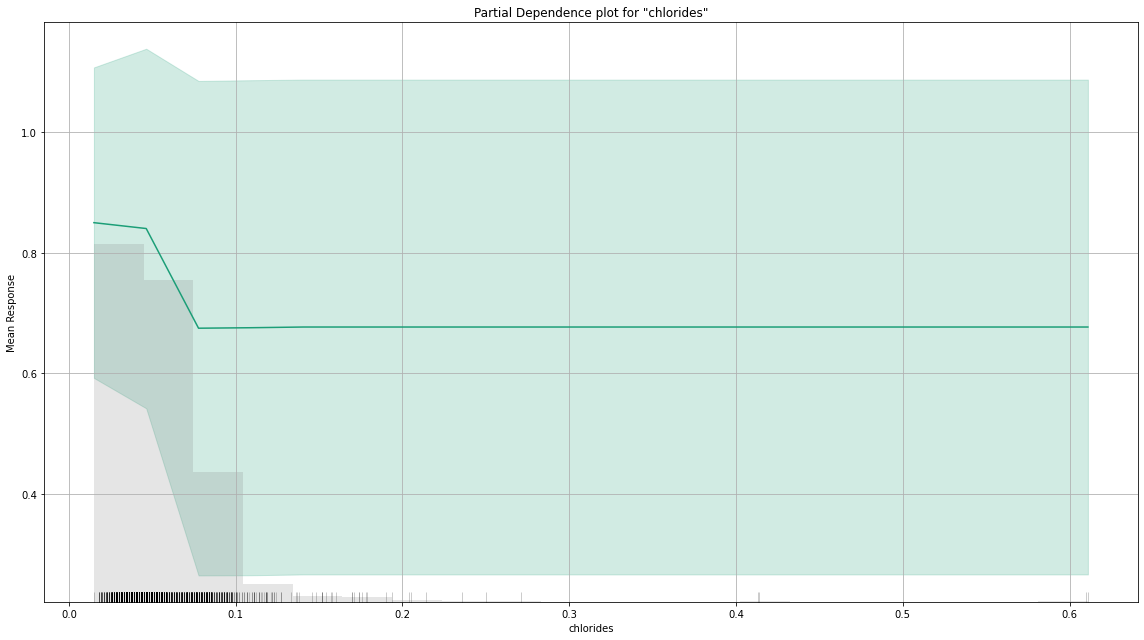

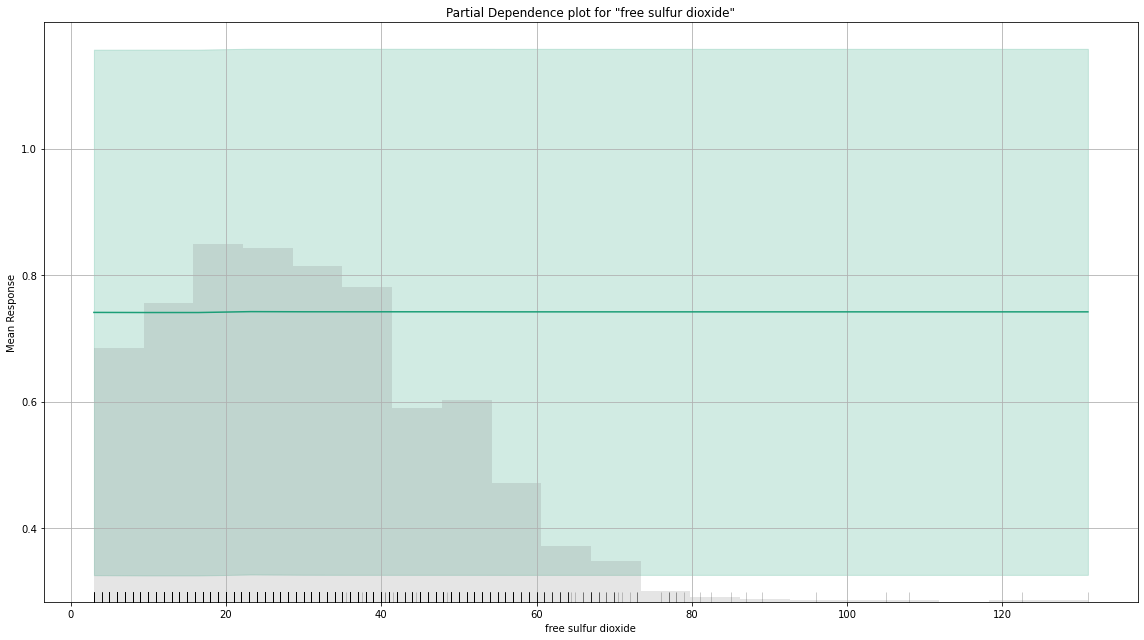

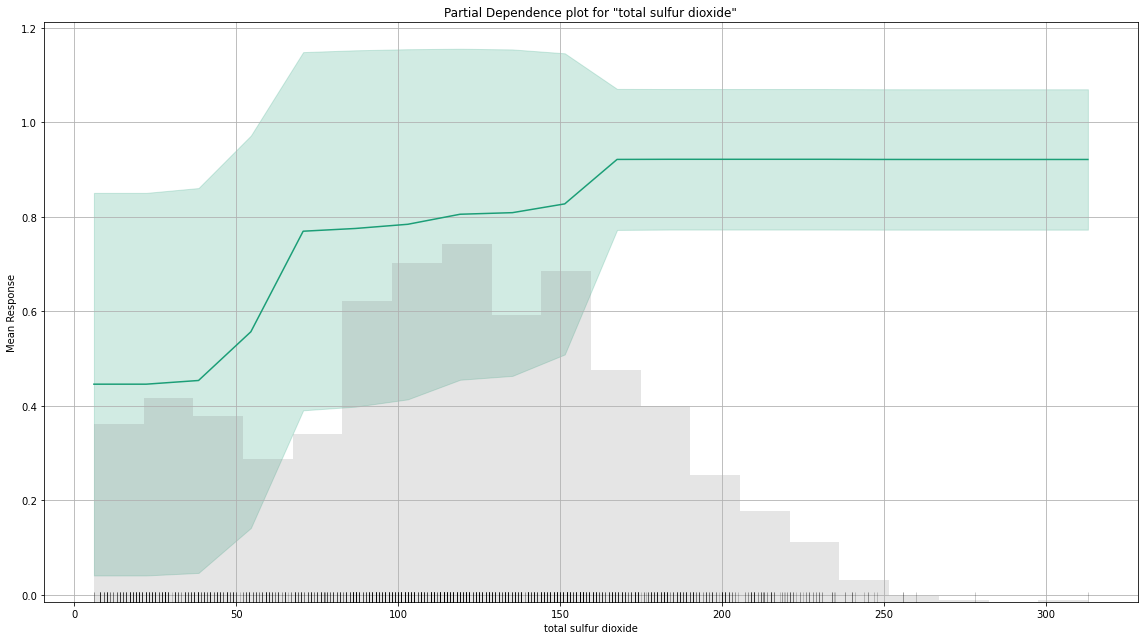

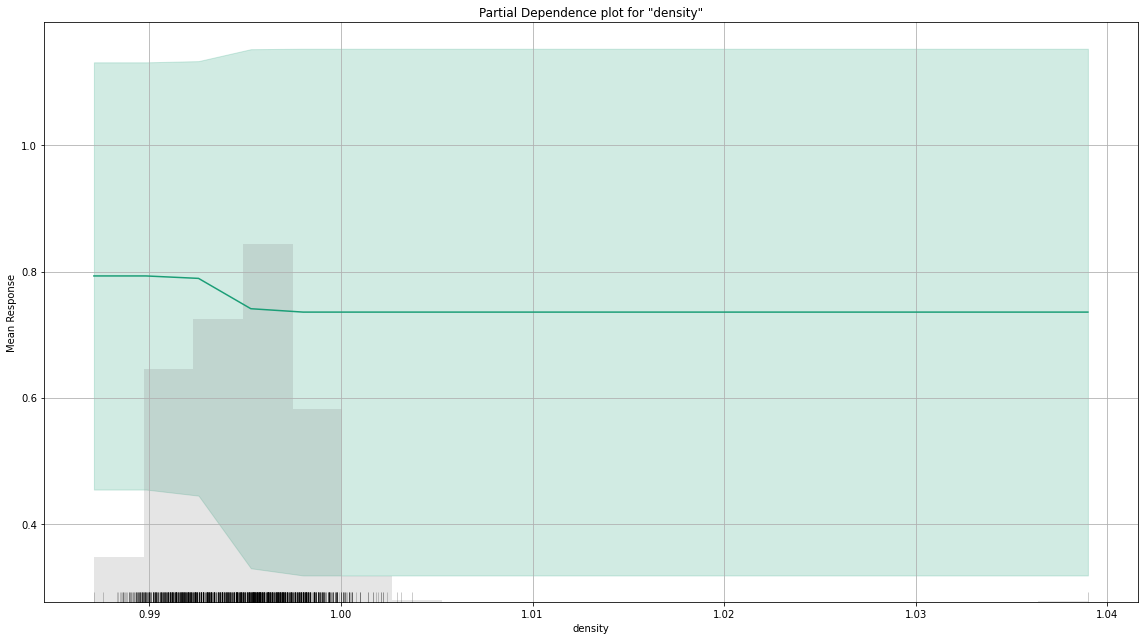

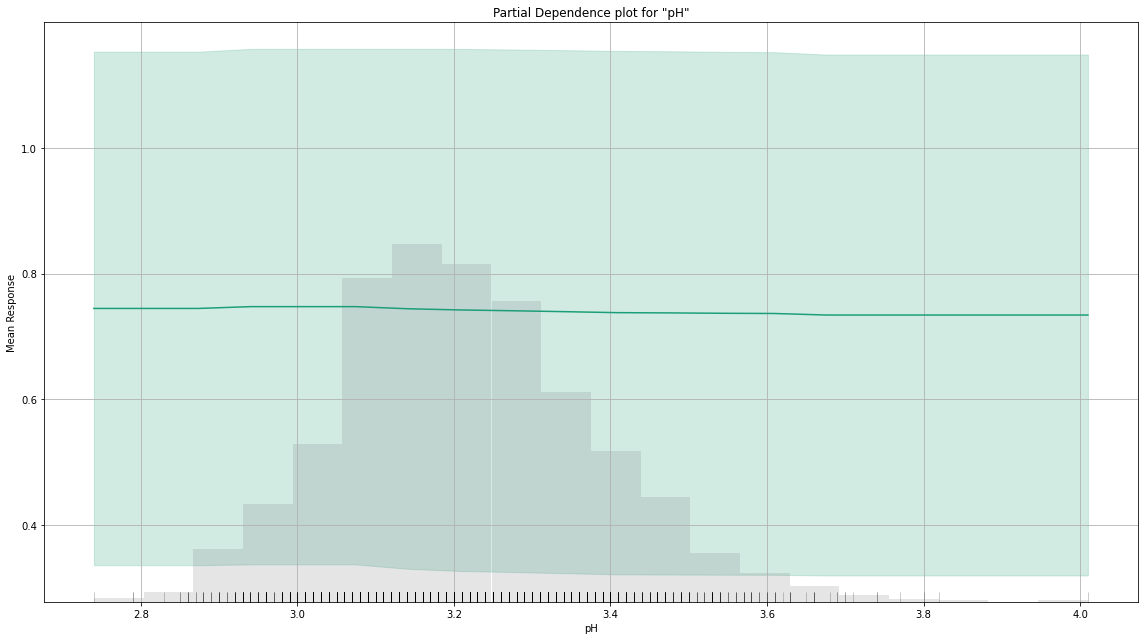

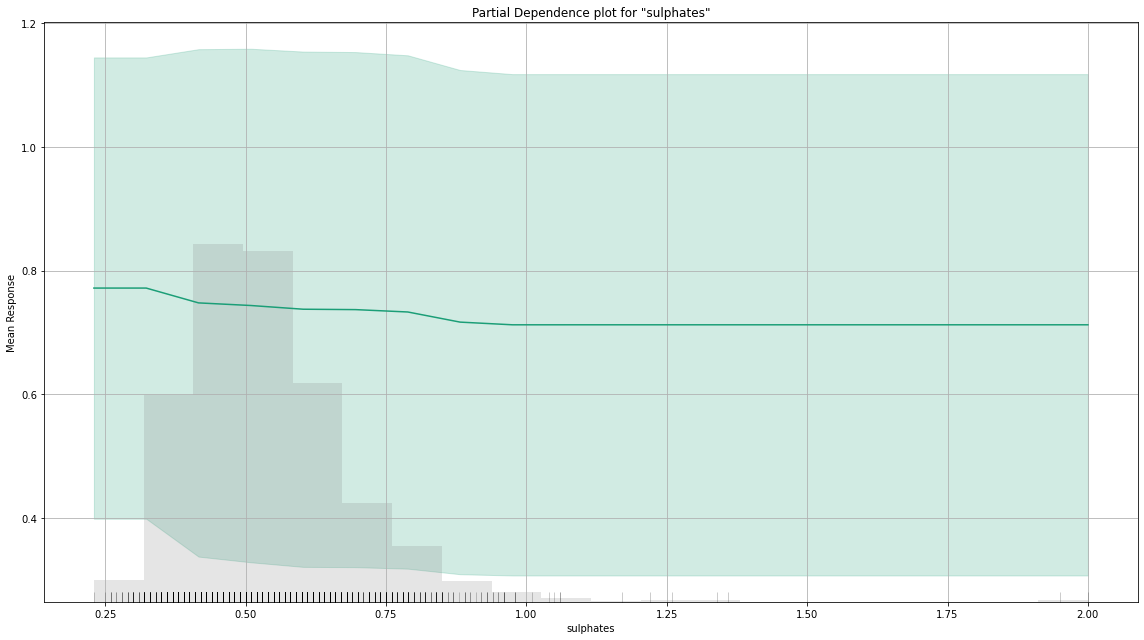

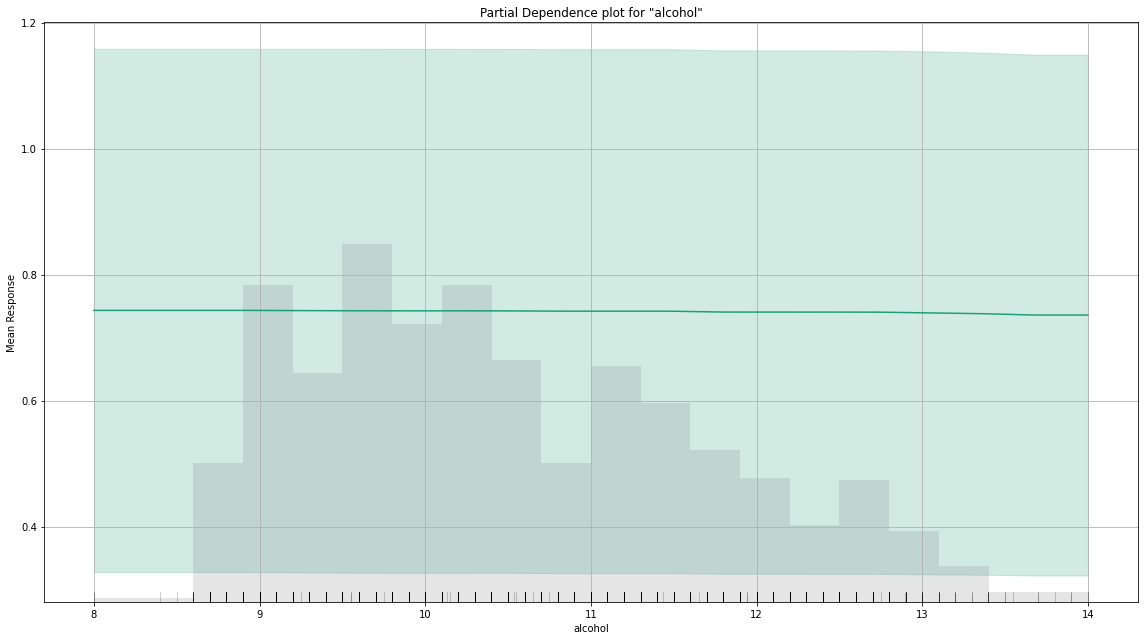

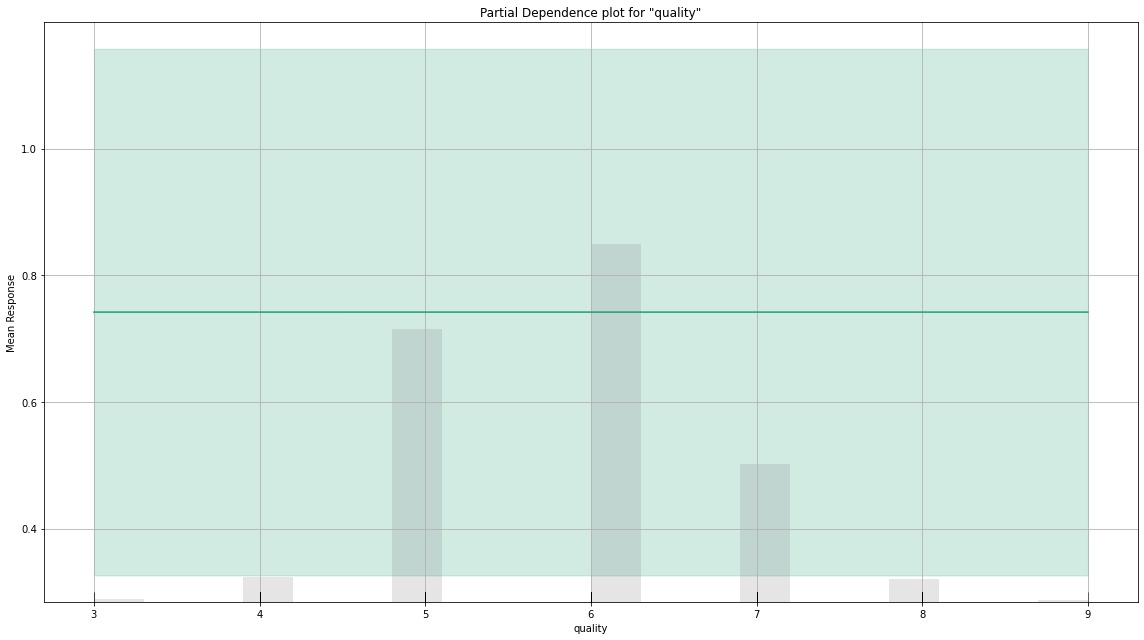

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## my_ensemble_gbm_grid_binomial


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5242186519237882: 


,,red,white,Error,Rate
0,red,408.0,13.0,0.0309,(13.0/421.0)
1,white,2.0,1209.0,0.0017,(2.0/1211.0)
2,Total,410.0,1222.0,0.0092,(15.0/1632.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [21]:
ensemble.explain(test)

/Users/fernandes/anaconda3/envs/h2o/lib/python3.8/site-packages/h2o/explanation/_explain.py:2799: UserWarning: No model with variable importance. Selecting all features to explain.
  warnings.warn("No model with variable importance. Selecting all features to explain.")


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

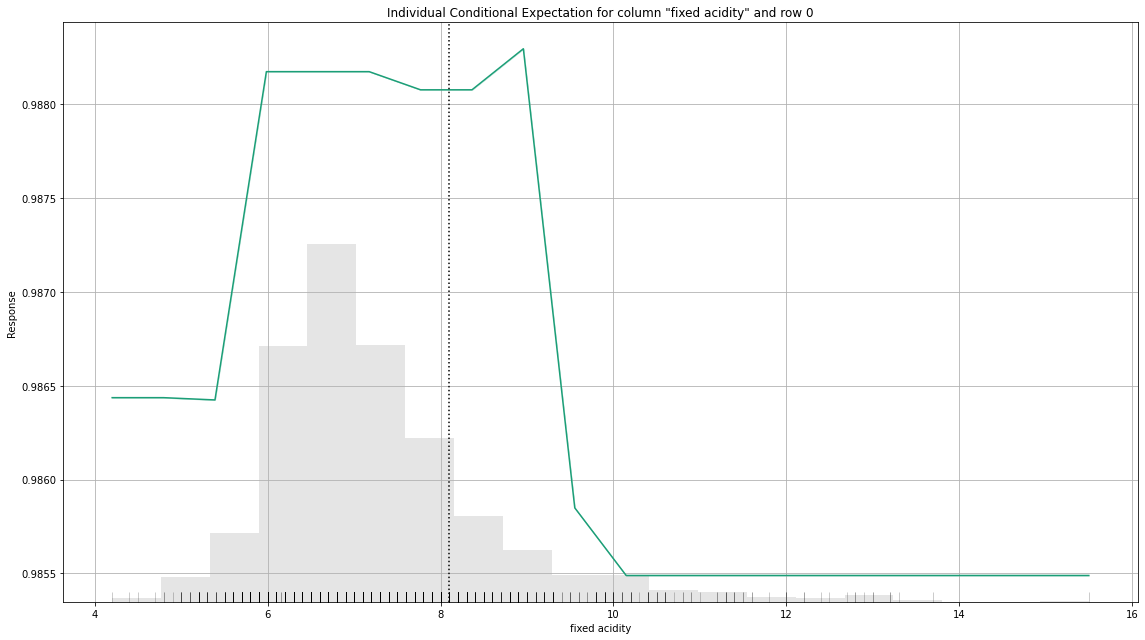

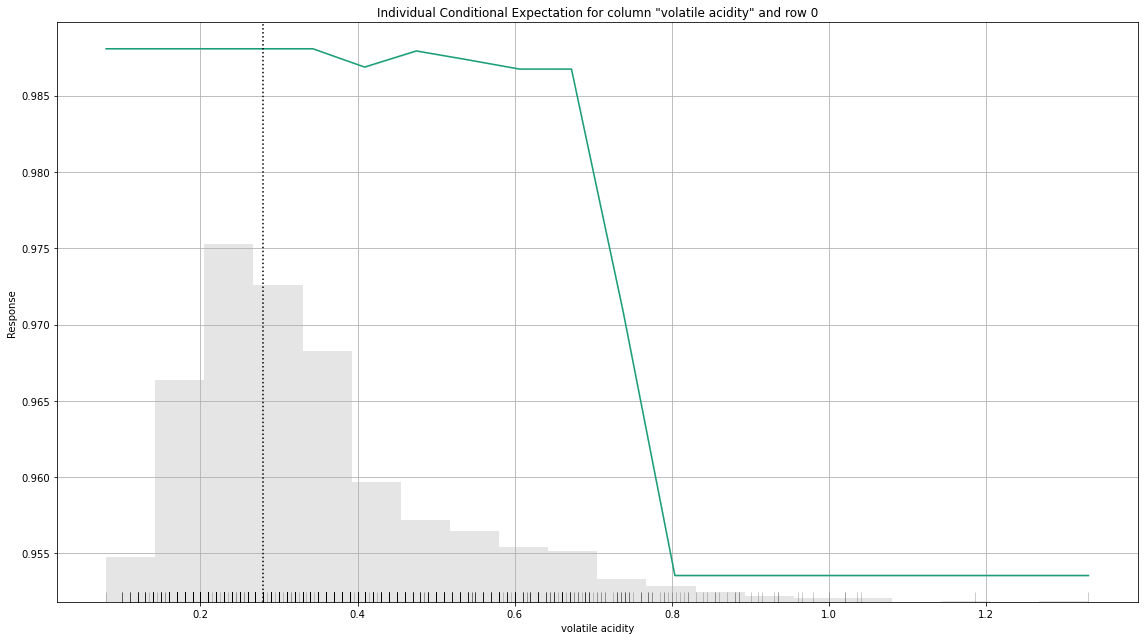

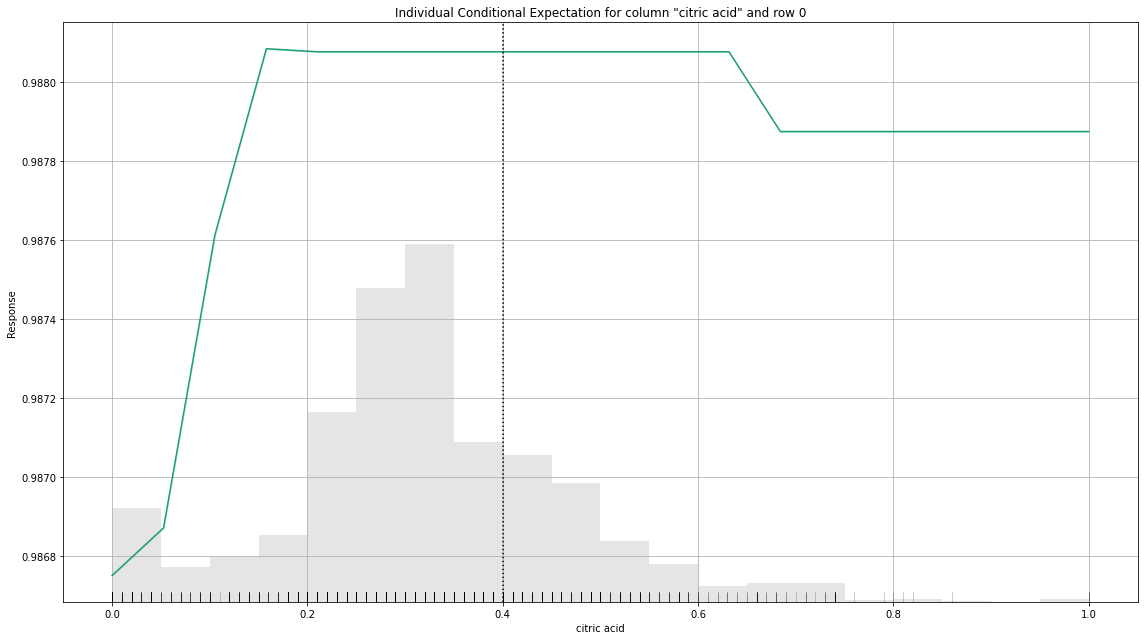

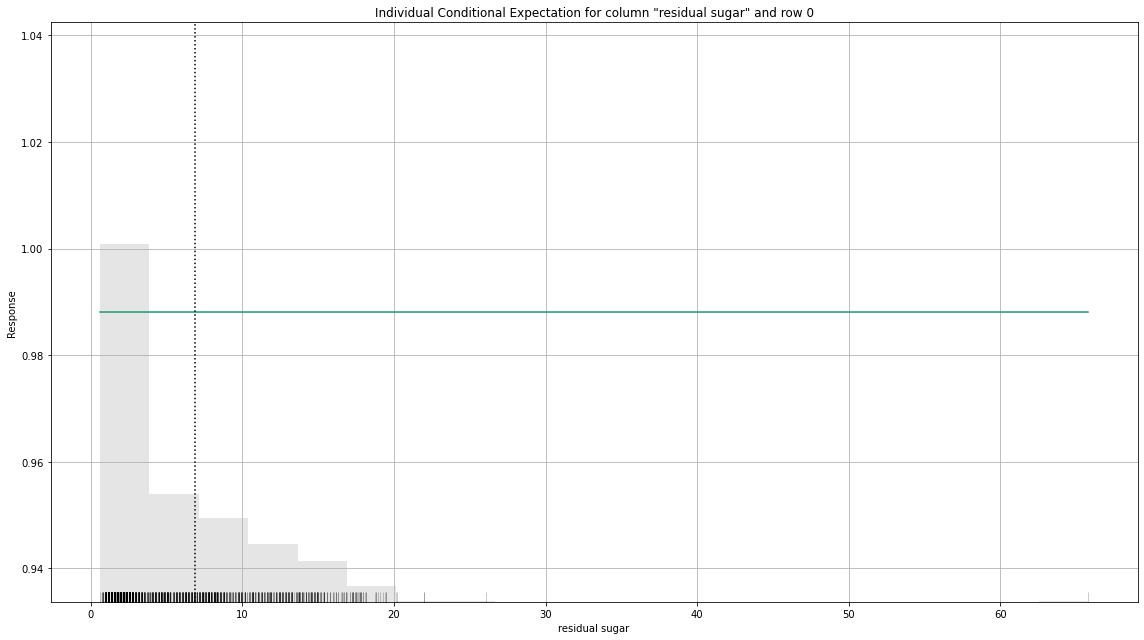

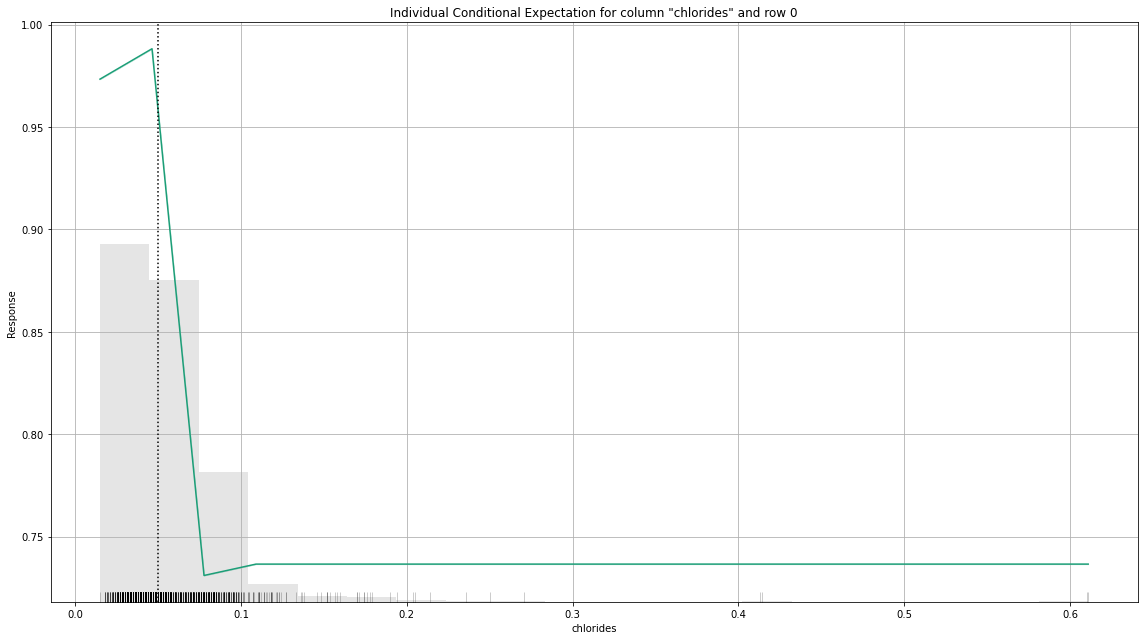

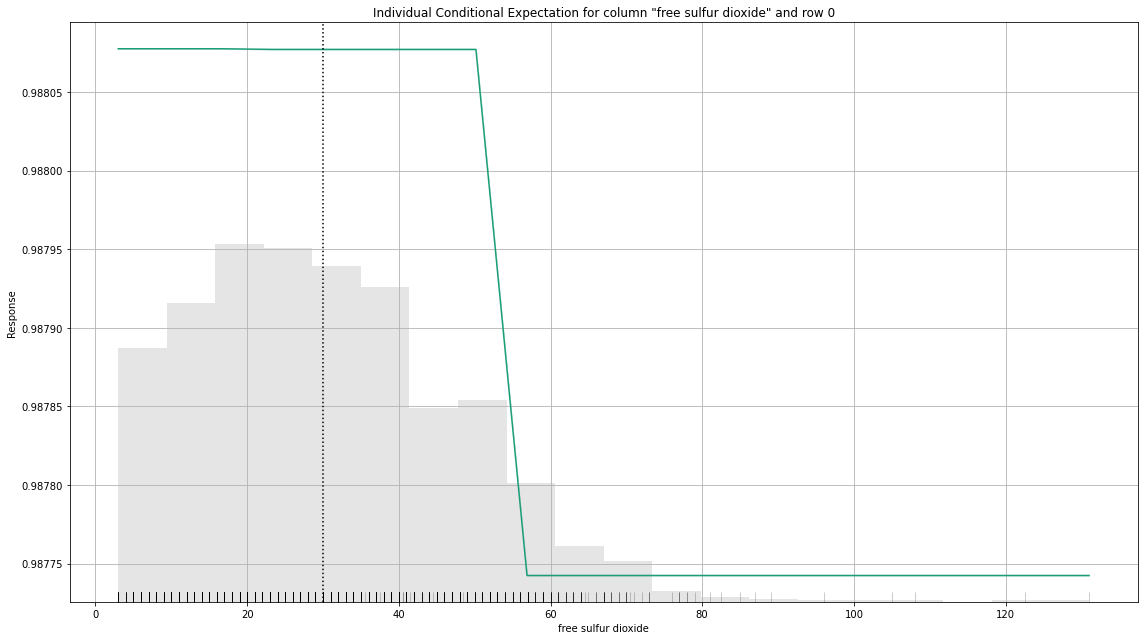

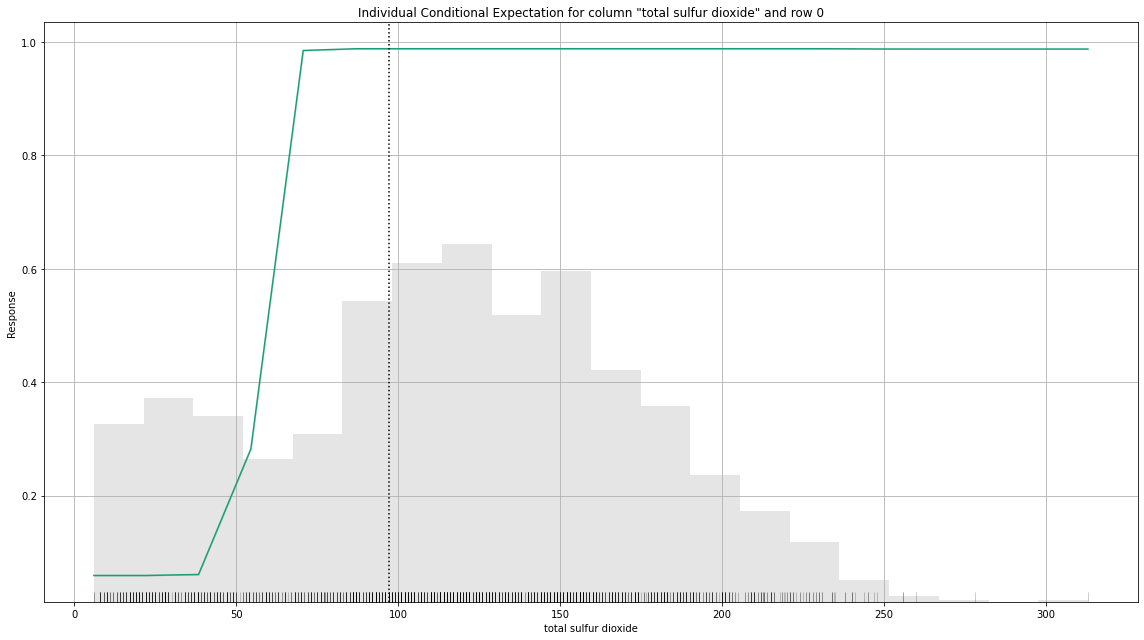

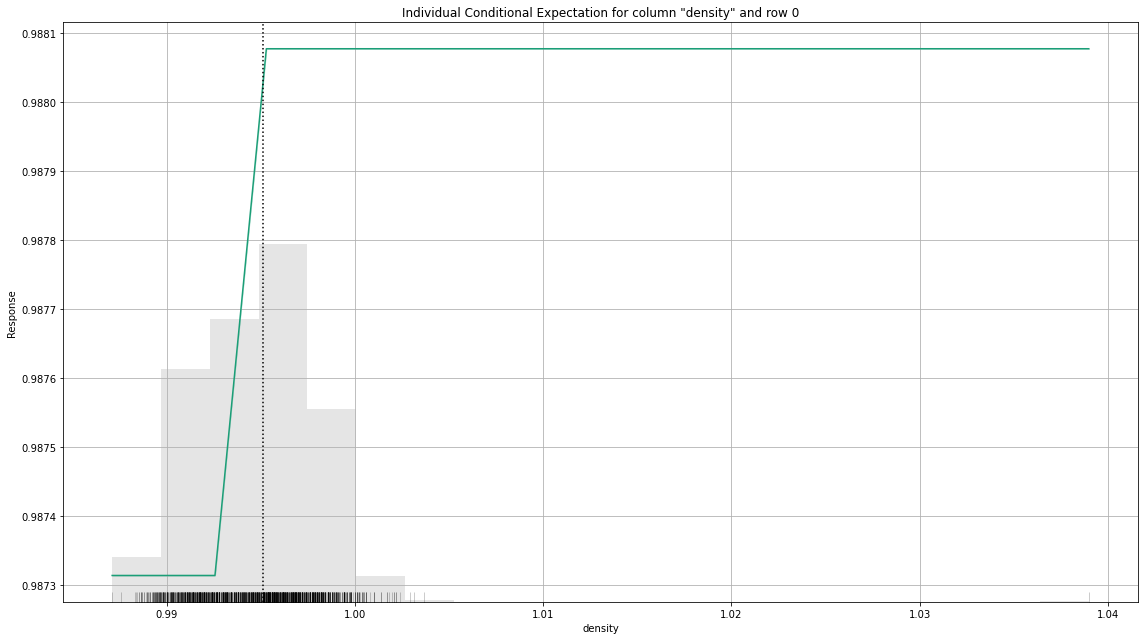

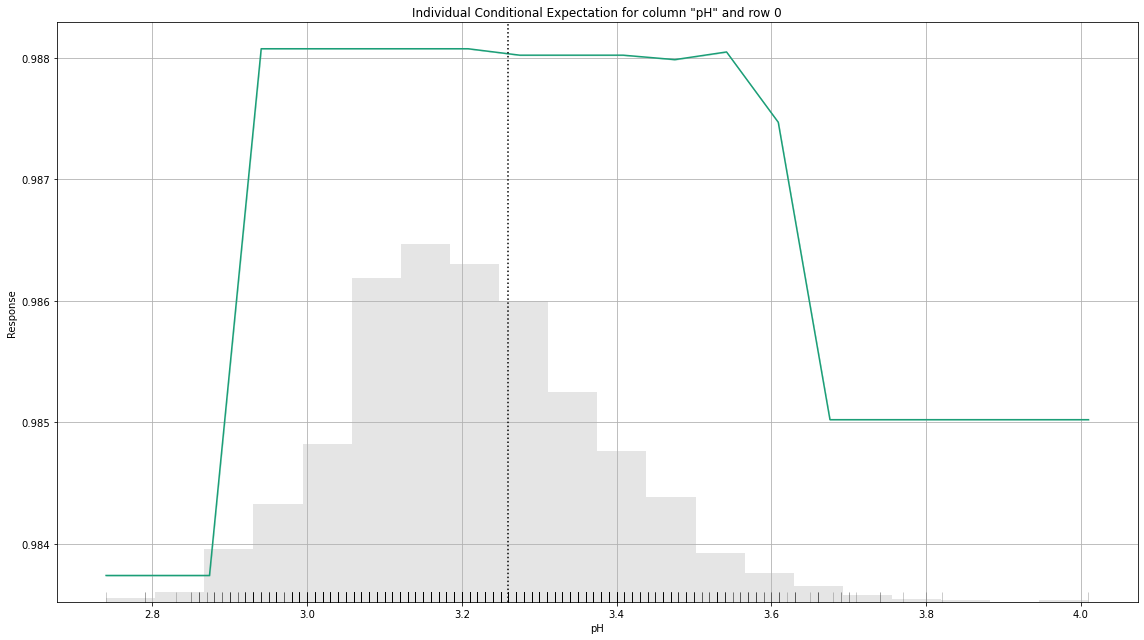

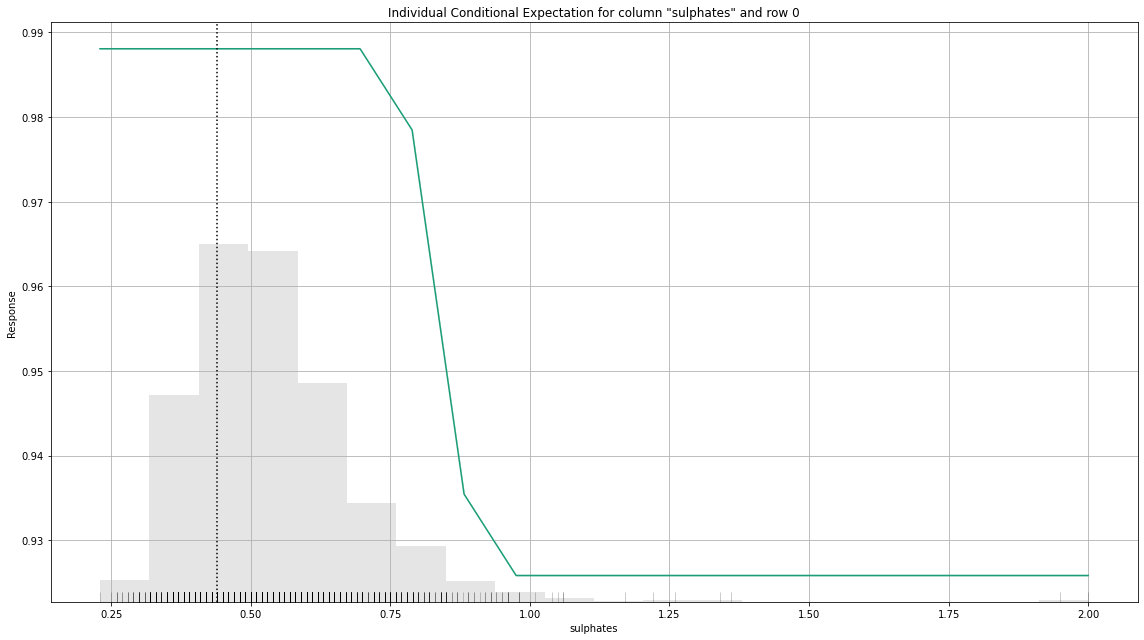

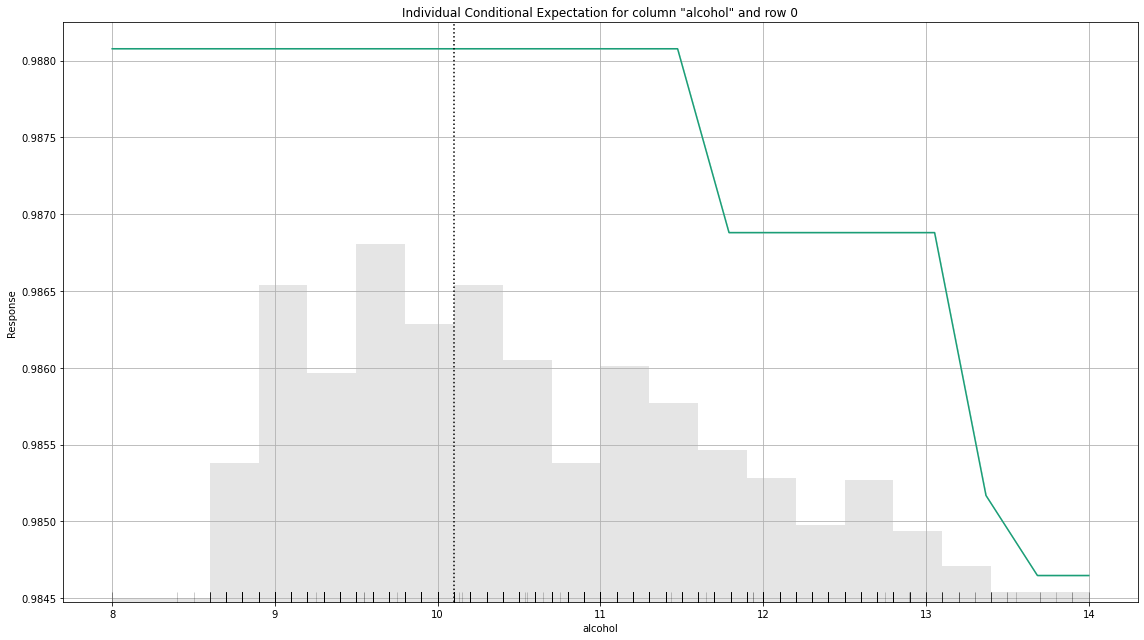

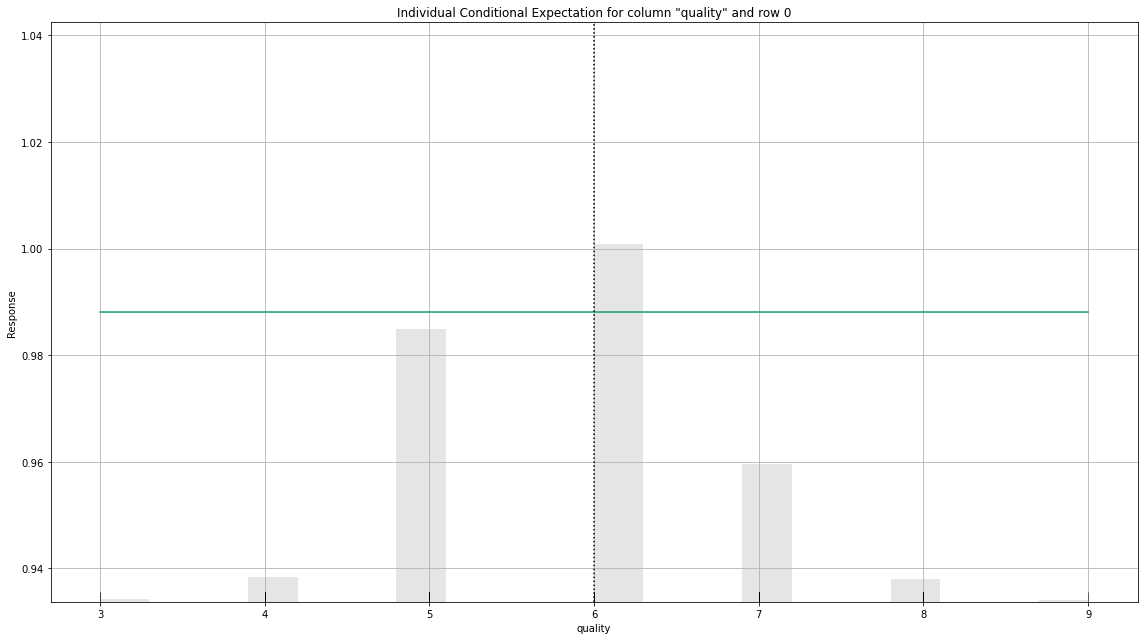

In [23]:
ensemble.explain_row(test, row_index=0);

In [24]:
# Run AutoML for 1 minute
aml = H2OAutoML(max_runtime_secs=60, seed=1)
aml.train(y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_1_20220220_165101


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,110.0,110.0,101887.0,10.0,10.0,10.0,38.0,118.0,68.94546




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0001408005843066429
RMSE: 0.011865942200543659
LogLoss: 0.0005572715720003793
Mean Per-Class Error: 0.00013561160835367508
AUC: 0.9999997697595784
AUCPR: 0.9999999264579104
Gini: 0.9999995395191568

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9868228488628693: 


,,red,white,Error,Rate
0,red,1178.0,0.0,0.0,(0.0/1178.0)
1,white,1.0,3686.0,0.0003,(1.0/3687.0)
2,Total,1179.0,3686.0,0.0002,(1.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.986823,0.999864,214.0
1,max f2,0.270285,0.999892,215.0
2,max f0point5,0.986823,0.999946,214.0
3,max accuracy,0.986823,0.999794,214.0
4,max precision,0.999991,1.000000,0.0
5,max recall,0.270285,1.000000,215.0
6,max specificity,0.999991,1.000000,0.0
7,max absolute_mcc,0.986823,0.999440,214.0
8,max min_per_class_accuracy,0.986823,0.999729,214.0
9,max mean_per_class_accuracy,0.986823,0.999864,214.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 75.78 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010277,0.999990,1.319501,1.319501,1.000000,0.999990,1.000000,0.999990,0.013561,0.013561,31.950095,31.950095,0.013561
1,2,0.020349,0.999989,1.319501,1.319501,1.000000,0.999989,1.000000,0.999990,0.013290,0.026851,31.950095,31.950095,0.026851
2,3,0.030010,0.999989,1.319501,1.319501,1.000000,0.999989,1.000000,0.999990,0.012747,0.039599,31.950095,31.950095,0.039599
3,4,0.040082,0.999989,1.319501,1.319501,1.000000,0.999989,1.000000,0.999989,0.013290,0.052889,31.950095,31.950095,0.052889
4,5,0.050154,0.999988,1.319501,1.319501,1.000000,0.999988,1.000000,0.999989,0.013290,0.066178,31.950095,31.950095,0.066178
5,6,0.100103,0.999987,1.319501,1.319501,1.000000,0.999988,1.000000,0.999988,0.065907,0.132086,31.950095,31.950095,0.132086
6,7,0.150257,0.999986,1.319501,1.319501,1.000000,0.999987,1.000000,0.999988,0.066178,0.198264,31.950095,31.950095,0.198264
7,8,0.200000,0.999985,1.319501,1.319501,1.000000,0.999986,1.000000,0.999987,0.065636,0.263900,31.950095,31.950095,0.263900
8,9,0.300308,0.999983,1.319501,1.319501,1.000000,0.999984,1.000000,0.999986,0.132357,0.396257,31.950095,31.950095,0.396257
9,10,0.400000,0.999979,1.319501,1.319501,1.000000,0.999981,1.000000,0.999985,0.131543,0.527800,31.950095,31.950095,0.527800




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.003538501285692703
RMSE: 0.059485303106672514
LogLoss: 0.017239350247696437
Mean Per-Class Error: 0.006484721475859522
AUC: 0.9994543302006822
AUCPR: 0.9998109619054891
Gini: 0.9989086604013644

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6659621778119297: 


,,red,white,Error,Rate
0,red,1164.0,14.0,0.0119,(14.0/1178.0)
1,white,4.0,3683.0,0.0011,(4.0/3687.0)
2,Total,1168.0,3697.0,0.0037,(18.0/4865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.665962,0.997562,219.0
1,max f2,0.163012,0.998375,233.0
2,max f0point5,0.911528,0.997068,205.0
3,max accuracy,0.747291,0.996300,217.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.072494,1.000000,241.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.747291,0.989906,217.0
8,max min_per_class_accuracy,0.977795,0.991511,188.0
9,max mean_per_class_accuracy,0.911528,0.993857,205.0



Gains/Lift Table: Avg response rate: 75.79 %, avg score: 76.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010277,9.999999e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.013561,0.013561,31.950095,31.950095,0.013561
1,2,0.022610,9.999998e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.016273,0.029835,31.950095,31.950095,0.029835
2,3,0.031038,9.999998e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.011120,0.040955,31.950095,31.950095,0.040955
3,4,0.042138,9.999998e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.014646,0.055601,31.950095,31.950095,0.055601
4,5,0.051593,9.999997e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.012476,0.068077,31.950095,31.950095,0.068077
5,6,0.100103,9.999993e-01,1.319501,1.319501,1.000000,1.000000,1.000000,1.000000,0.064009,0.132086,31.950095,31.950095,0.132086
6,7,0.150257,9.999979e-01,1.319501,1.319501,1.000000,0.999998,1.000000,0.999999,0.066178,0.198264,31.950095,31.950095,0.198264
7,8,0.200000,9.999965e-01,1.319501,1.319501,1.000000,0.999997,1.000000,0.999999,0.065636,0.263900,31.950095,31.950095,0.263900
8,9,0.300103,9.999518e-01,1.319501,1.319501,1.000000,0.999982,1.000000,0.999993,0.132086,0.395986,31.950095,31.950095,0.395986
9,10,0.400000,9.998804e-01,1.319501,1.319501,1.000000,0.999927,1.000000,0.999977,0.131814,0.527800,31.950095,31.950095,0.527800




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.996506,0.001867,0.998972,0.995889,0.997945,0.994861,0.994861
1,auc,0.998870,0.001806,0.999994,0.999386,0.999954,0.999327,0.995688
2,err,0.003494,0.001867,0.001028,0.004111,0.002055,0.005139,0.005139
3,err_count,3.400000,1.816590,1.000000,4.000000,2.000000,5.000000,5.000000
4,f0point5,0.996809,0.001773,0.998917,0.997290,0.997834,0.994602,0.995402
5,f1,0.997698,0.001229,0.999323,0.997290,0.998645,0.996619,0.996615
6,f2,0.998590,0.001039,0.999729,0.997290,0.999458,0.998645,0.997831
7,lift_top_group,1.319502,0.000980,1.318428,1.318428,1.320217,1.320217,1.320217
8,logloss,0.017726,0.010116,0.003642,0.021098,0.010931,0.026763,0.026196
9,max_per_class_error,0.011875,0.006953,0.004255,0.008511,0.008475,0.021186,0.016949



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-02-20 16:51:33,3.778 sec,0.0,0.428377,0.553532,0.500000,0.757862,1.000000,0.242138
1,,2022-02-20 16:51:33,3.810 sec,5.0,0.262376,0.274188,0.999575,0.999857,1.319501,0.003905
2,,2022-02-20 16:51:33,3.844 sec,10.0,0.169385,0.161037,0.999777,0.999926,1.319501,0.003289
3,,2022-02-20 16:51:33,3.876 sec,15.0,0.114602,0.100077,0.999813,0.999936,1.319501,0.003083
4,,2022-02-20 16:51:33,3.909 sec,20.0,0.080753,0.063390,0.999824,0.999939,1.319501,0.002261
5,,2022-02-20 16:51:33,3.943 sec,25.0,0.060472,0.041604,0.999908,0.999969,1.319501,0.001644
6,,2022-02-20 16:51:33,3.978 sec,30.0,0.047607,0.027737,0.999954,0.999985,1.319501,0.001233
7,,2022-02-20 16:51:34,4.012 sec,35.0,0.038991,0.018687,0.999996,0.999999,1.319501,0.000411
8,,2022-02-20 16:51:34,4.046 sec,40.0,0.031689,0.012725,0.999999,1.000000,1.319501,0.000411
9,,2022-02-20 16:51:34,4.088 sec,45.0,0.026082,0.008909,1.000000,1.000000,1.319501,0.000206



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total sulfur dioxide,2050.402832,1.000000,0.475475
1,chlorides,1259.511475,0.614275,0.292073
2,volatile acidity,335.685028,0.163717,0.077843
3,density,218.408310,0.106520,0.050647
4,sulphates,121.330933,0.059174,0.028136
5,residual sugar,106.188469,0.051789,0.024624
6,pH,65.795219,0.032089,0.015257
7,fixed acidity,52.387806,0.025550,0.012148
8,alcohol,43.286434,0.021111,0.010038
9,free sulfur dioxide,31.466555,0.015347,0.007297


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_4_AutoML_1_20220220_165101,0.999454,0.0172394,0.999811,0.00648472,0.0594853,0.0035385,870,0.019772,GBM
GBM_5_AutoML_1_20220220_165101,0.999221,0.0213849,0.999731,0.0107292,0.0684376,0.00468371,654,0.010752,GBM
GBM_1_AutoML_1_20220220_165101,0.999132,0.0148605,0.999657,0.00420926,0.0537547,0.00288956,1134,0.019235,GBM
StackedEnsemble_BestOfFamily_3_AutoML_1_20220220_165101,0.999123,0.0154114,0.999652,0.00663795,0.0575555,0.00331263,666,0.026537,StackedEnsemble
GBM_3_AutoML_1_20220220_165101,0.999118,0.0183594,0.999641,0.00561821,0.0629208,0.00395903,556,0.011396,GBM
GBM_2_AutoML_1_20220220_165101,0.999065,0.0182741,0.999631,0.0054826,0.0608081,0.00369762,570,0.013228,GBM
StackedEnsemble_AllModels_1_AutoML_1_20220220_165101,0.999031,0.0150396,0.999612,0.00634911,0.0563059,0.00317036,776,0.065234,StackedEnsemble
XGBoost_3_AutoML_1_20220220_165101,0.999013,0.0176111,0.999603,0.00662033,0.0615121,0.00378374,447,0.004972,XGBoost
StackedEnsemble_AllModels_2_AutoML_1_20220220_165101,0.998954,0.0156509,0.999563,0.00606027,0.0576464,0.00332311,753,0.061188,StackedEnsemble
XRT_1_AutoML_1_20220220_165101,0.998896,0.0371282,0.999466,0.00801168,0.0800349,0.00640559,234,0.00518,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_4_AutoML_1_20220220_165101


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5632166189434545: 


,,red,white,Error,Rate
0,red,417.0,4.0,0.0095,(4.0/421.0)
1,white,2.0,1209.0,0.0017,(2.0/1211.0)
2,Total,419.0,1213.0,0.0037,(6.0/1632.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

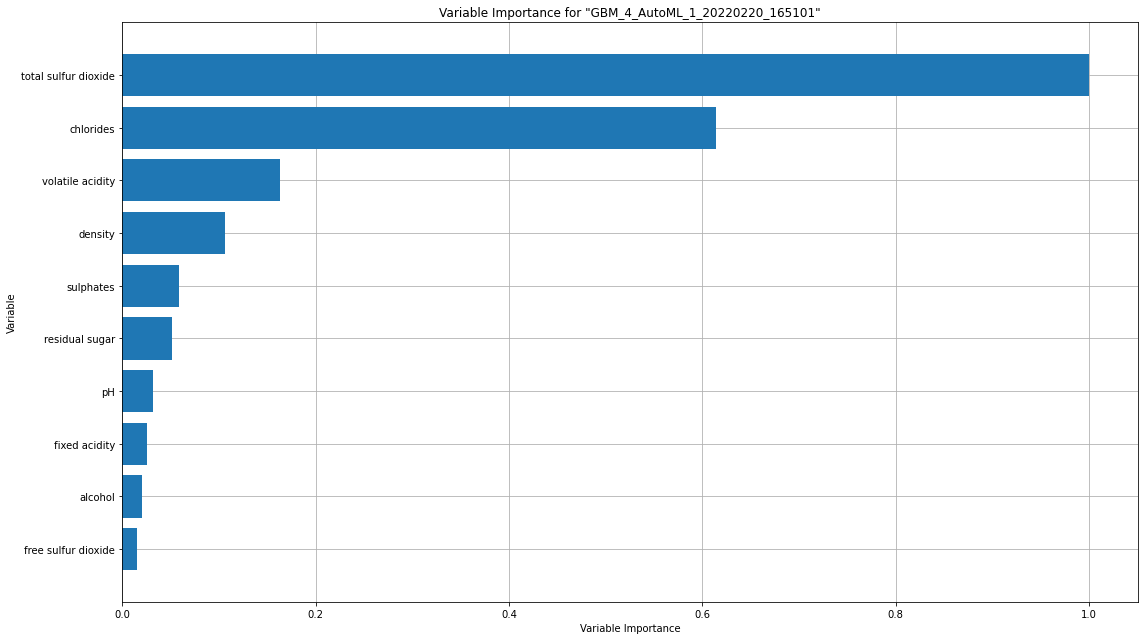

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

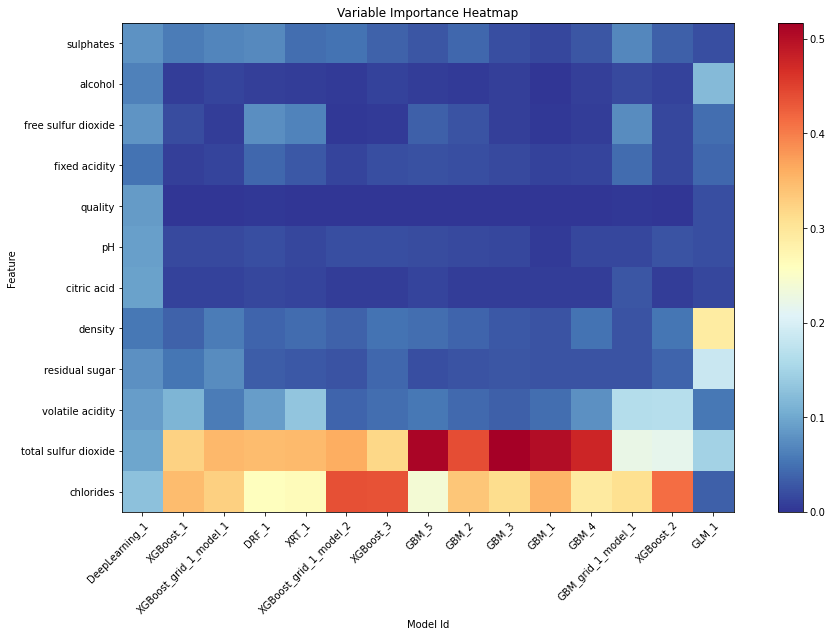

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

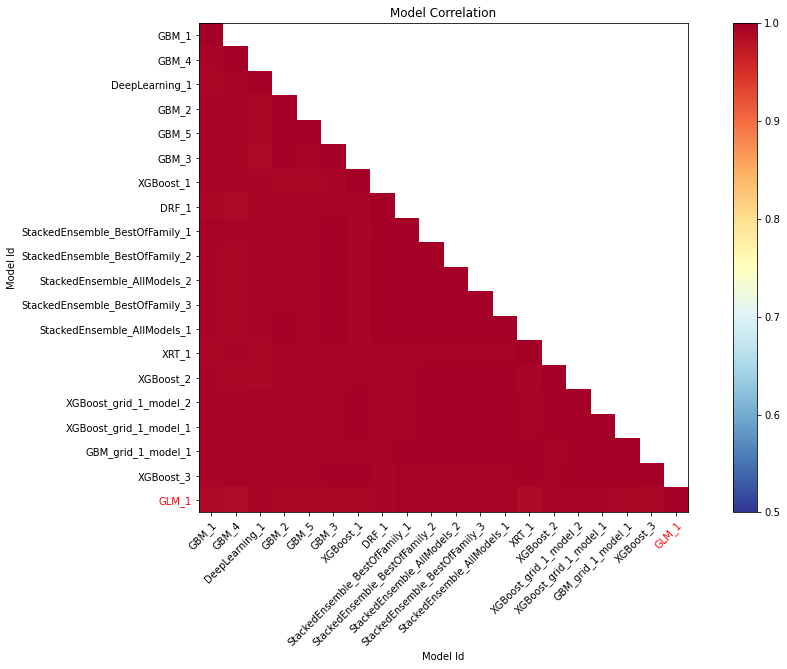

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

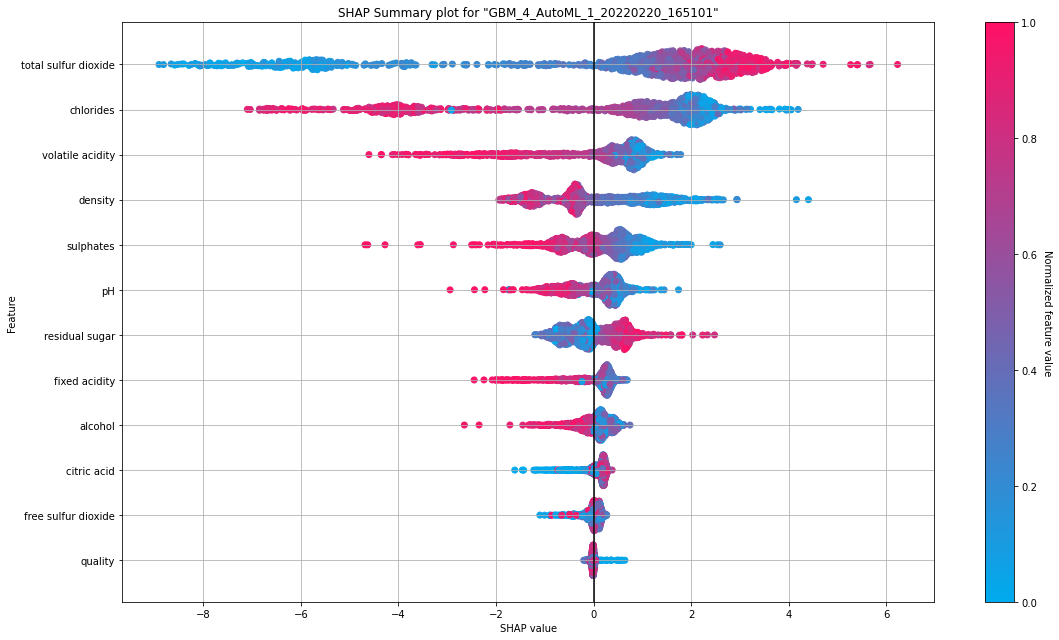

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

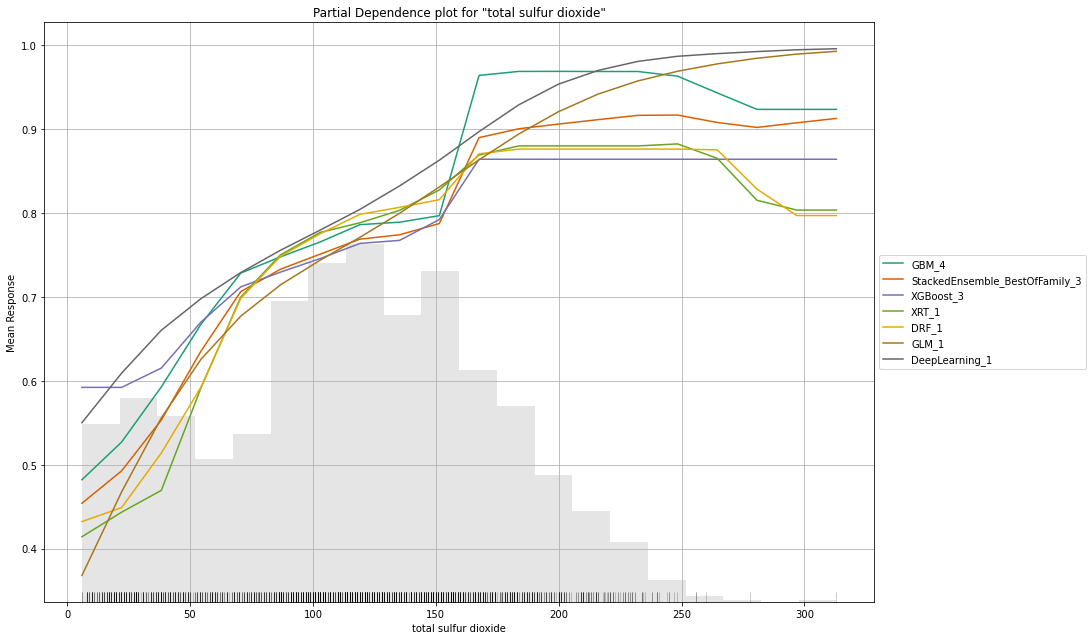

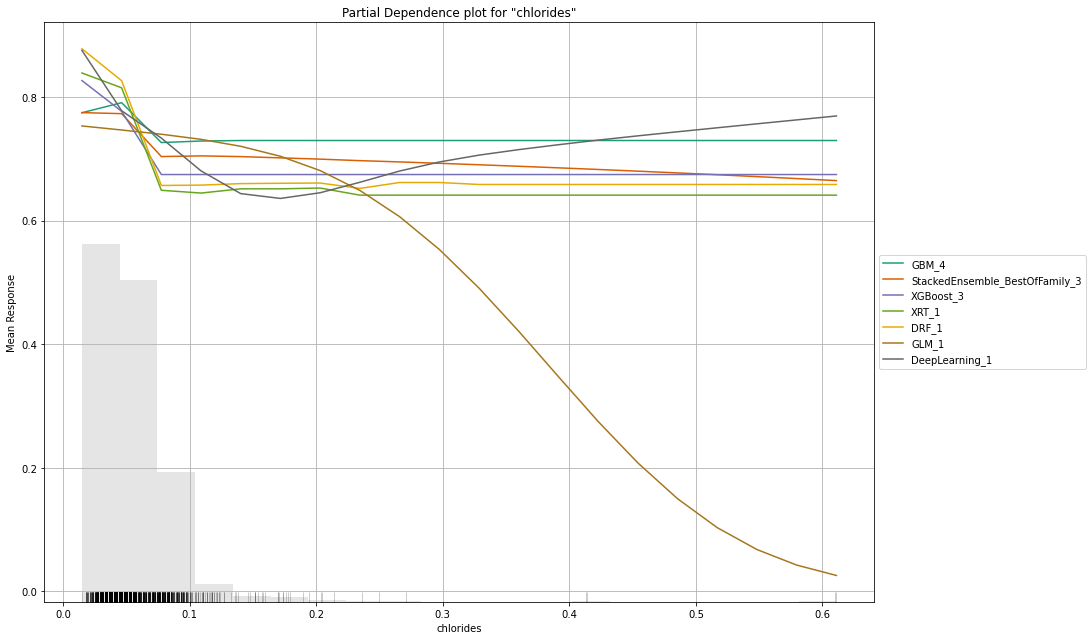

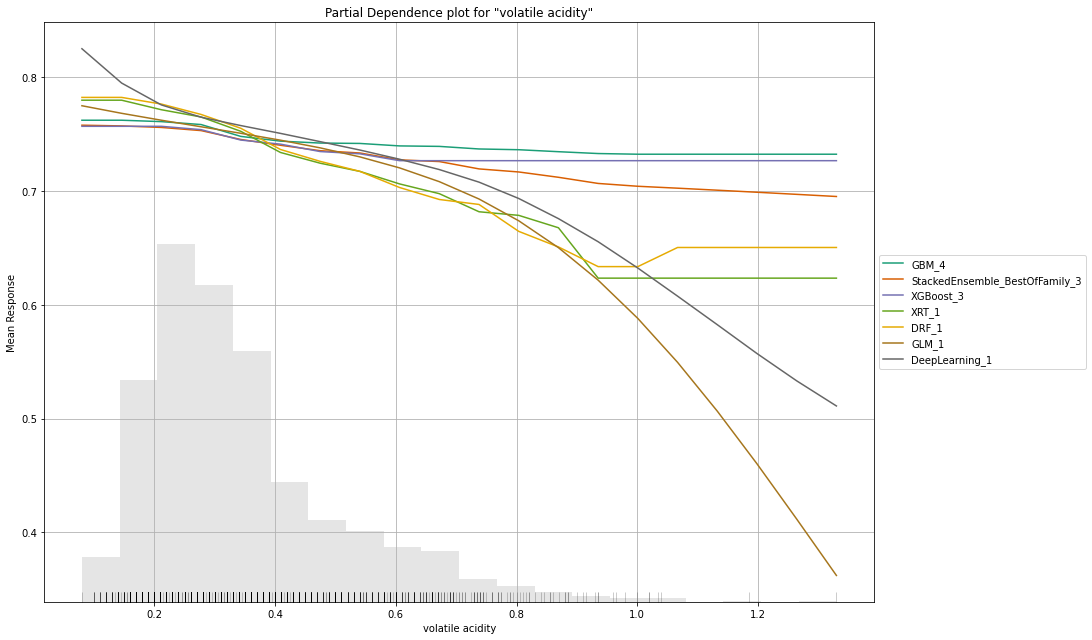

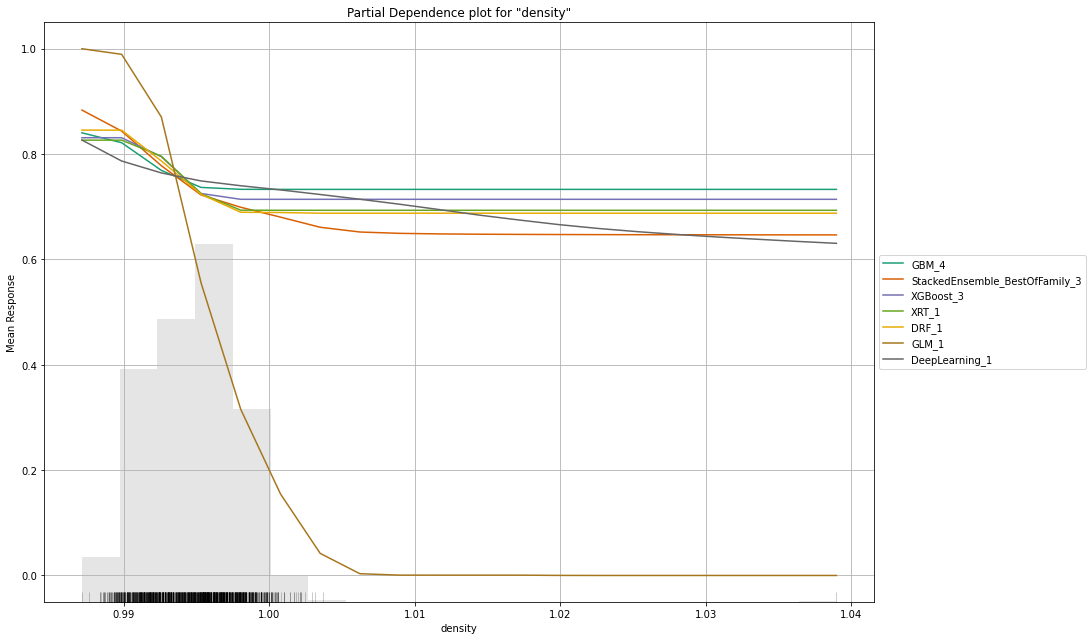

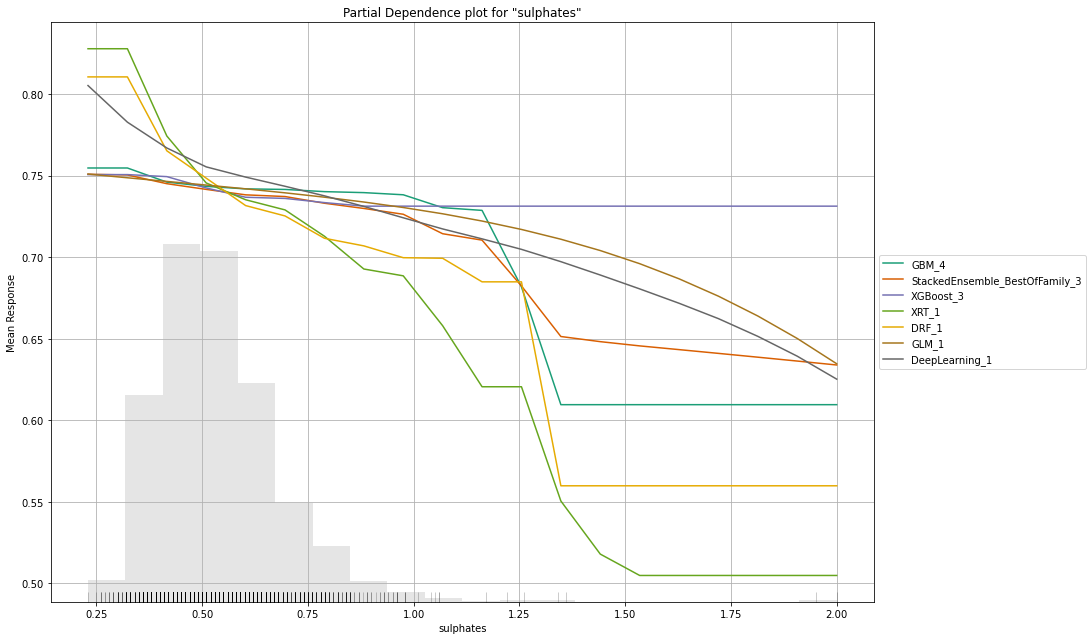

In [25]:
# Explain leader model & compare with all AutoML models
exa = aml.explain(test)

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_4_AutoML_1_20220220_165101


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5632166189434545: 


,,red,white,Error,Rate
0,red,417.0,4.0,0.0095,(4.0/421.0)
1,white,2.0,1209.0,0.0017,(2.0/1211.0)
2,Total,419.0,1213.0,0.0037,(6.0/1632.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

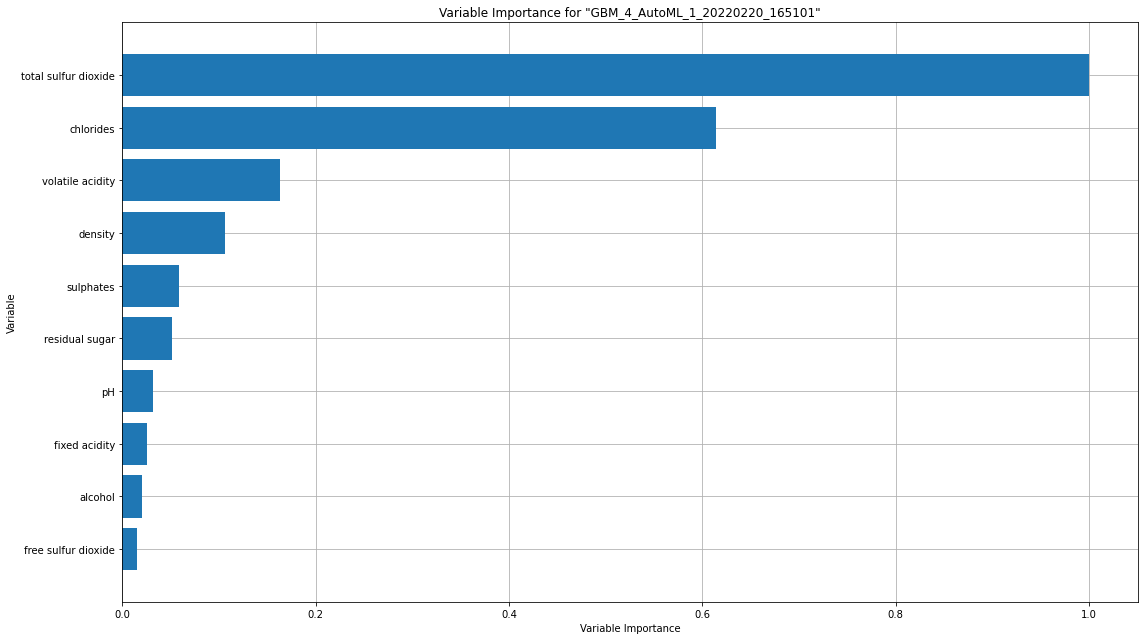

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

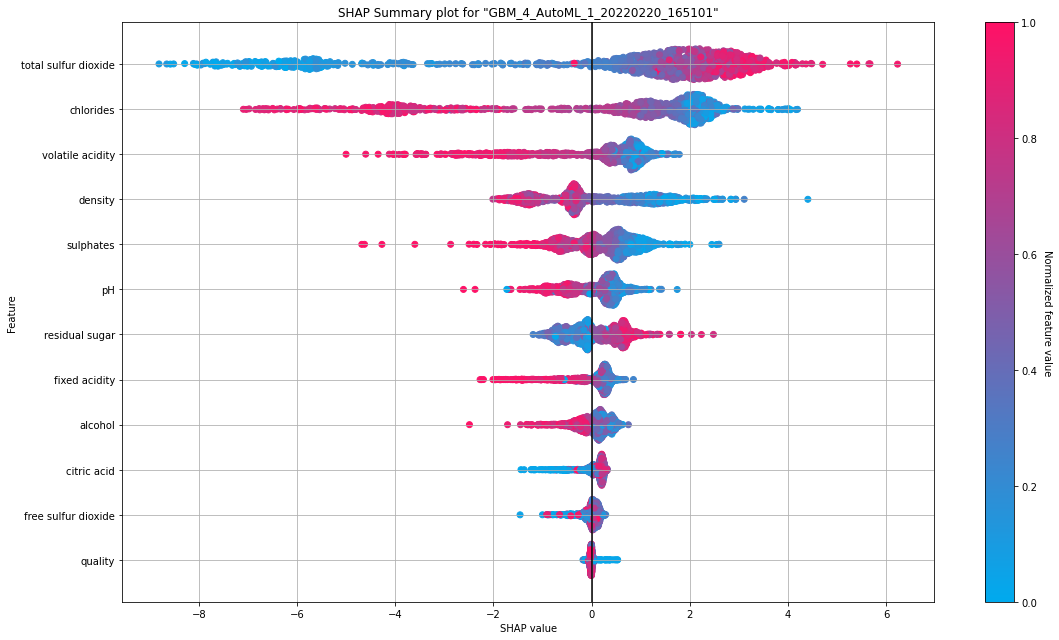

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

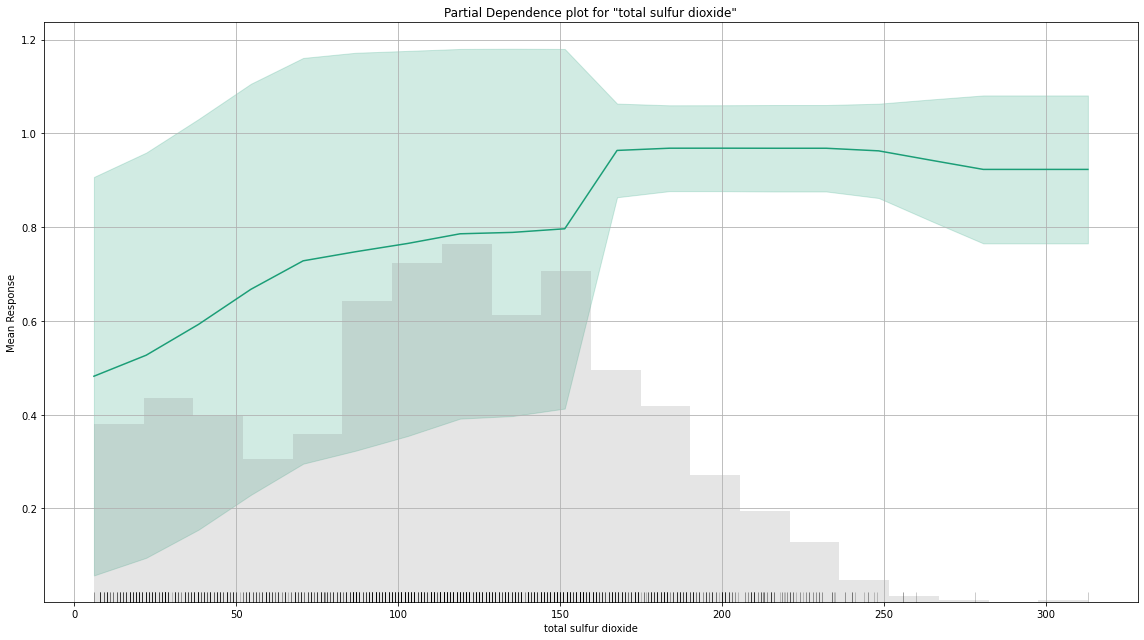

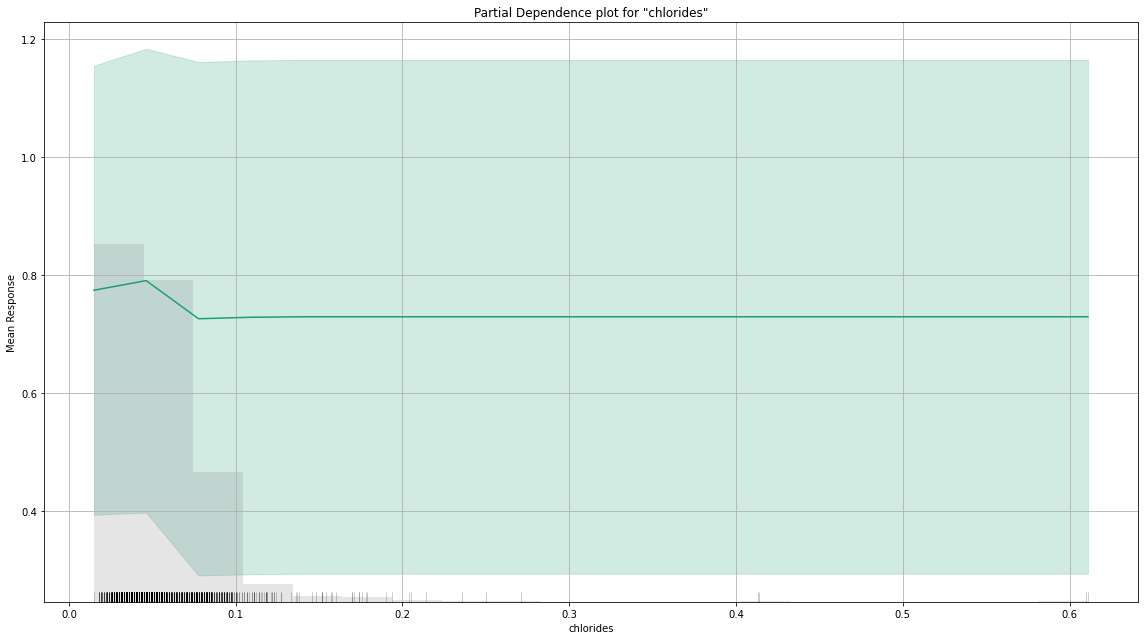

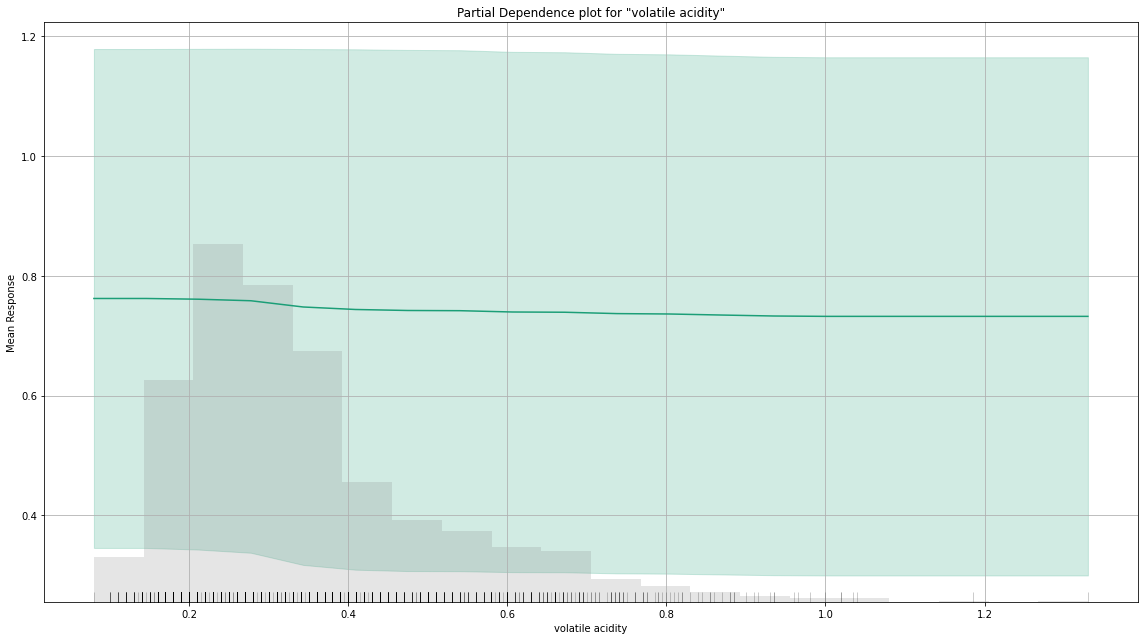

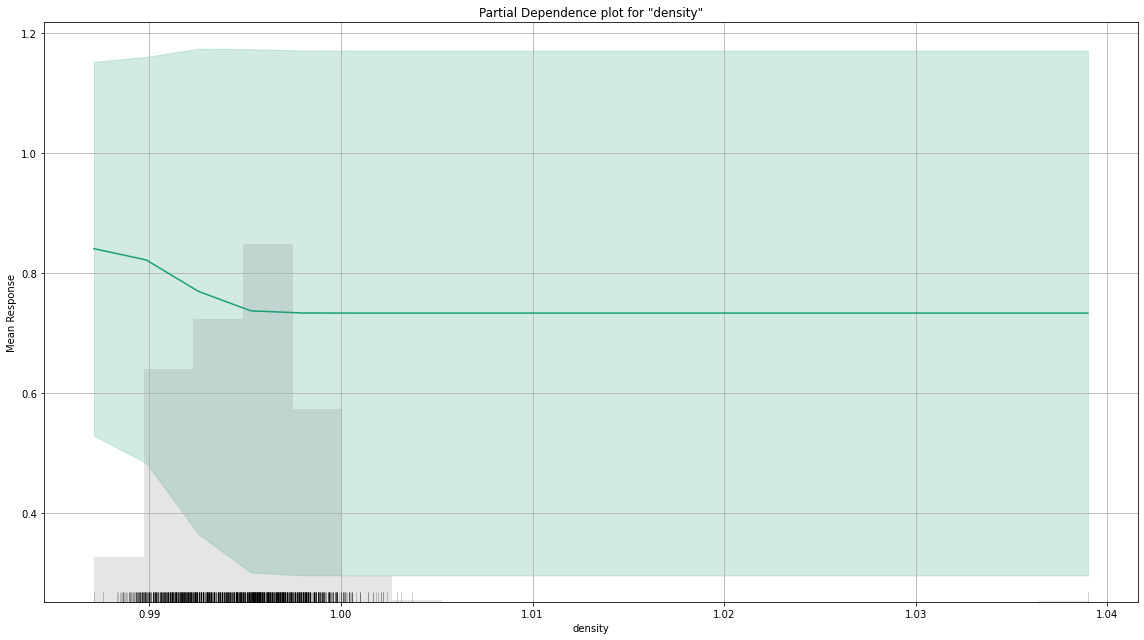

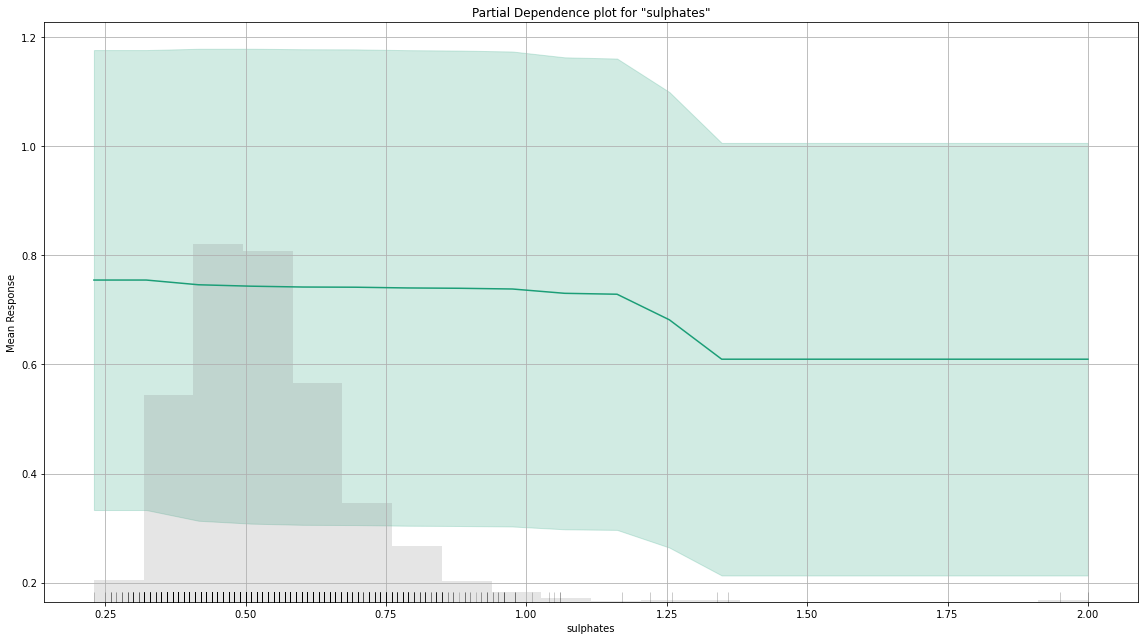

In [26]:
# Explain a single H2O model (e.g. leader model from AutoML)
exm = aml.leader.explain(test)

In [31]:
# save the model
model_path = h2o.save_model(model=aml.leader, path="mymodel", force=True)
print (model_path)

/Users/fernandes/Documents/Learning_AI/mymodel/GBM_4_AutoML_1_20220220_165101


In [58]:
h2o.cluster_info()

/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/ipykernel_89089/3484606868.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().show_status()``.
  h2o.cluster_info()


H2O_cluster_uptime:,42 mins 51 secs
H2O_cluster_timezone:,Europe/Brussels
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_fernandes_vr84fc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.971 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [60]:
h2o.cluster_status()

/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/ipykernel_89089/2774355338.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().show_status(True)``.
  h2o.cluster_status()


H2O_cluster_uptime:,43 mins 19 secs
H2O_cluster_timezone:,Europe/Brussels
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_fernandes_vr84fc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.971 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Nodes info:,Node 1
h2o,/127.0.0.1:54321
healthy,True
last_ping,1645374568430.0000000
num_cpus,4
sys_load,1.7119141
mem_value_size,31391806
free_mem,8558542786.0000000
pojo_mem,0
swap_mem,0
free_disk,166243336192.0000000


In [65]:
h2o.ls()

H2OConnectionError: Connection was closed, and can no longer be used.

In [64]:
h2o.shutdown()

H2O session _sid_aeee closed.


/var/folders/ms/jm3m3j2d3ks2q1d9r68xlw80l66hfh/T/ipykernel_89089/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
